In [412]:
#libraries
library(tidyverse)
library(RColorBrewer)
library(dplyr)
library(ggpubr)
library(patchwork)

ERROR: Error in library(patchwork): there is no package called 'patchwork'


In [378]:
path_files <- "C://Users//jziac//OneDrive//Documents//programovani//projekty//elite//data//data_report//"

In [379]:
players_file_name <- "nhl_player_stats.csv"
goalies_file_name <- "nhl_goalie_stats.csv"

In [380]:
#graphics set up
gg_size <- 11
plot_size <- 7
size_multiplier <- 2
options(repr.plot.width = plot_size*size_multiplier, repr.plot.height = plot_size*size_multiplier)
def_plot_setup <- theme_light() + 
theme(text=element_text(size = gg_size*size_multiplier,  family = "helvetica"))
my_colours <- brewer.pal(n = 9,"Paired")

In [406]:
create_comparative_measure <- function(df, position_match, reg_seas, stat) {
  if (position_match == "defense") {
    match <- "D"
  }
  else if (position_match == "attack") {
    match <-"W|C"
  }
  else if (position_match == "all") {
    match <- "W|C|D"
  }
  else if (position_match == "goalie") {
    match <- "G"
  }

  df_2 <- df %>%
    group_by(season) %>%
    filter(gp > 0) %>%
    mutate(median_games = median(gp, na.rm = TRUE)) %>%
    filter(gp >= median_games)

  season_values <- df_2 %>%
    filter(grepl(match, position)) %>%
    filter(regular_season == reg_seas) %>%
    group_by(season) %>%
    summarize(
    mad = mad({{ stat }}, na.rm=TRUE), 
    median = median({{ stat }}, na.rm = TRUE)
    )

  dominance_df <- df_2 %>%
    filter(grepl(match, position)) %>%
    filter(regular_season == reg_seas) %>%
    left_join(season_values, by = "season") %>%
    mutate(measure = ({{ stat }} - median)/mad) %>%
    arrange(desc(measure))
}

create_career_measure <- function(df) {
  career_measure <- df %>%
    group_by(name) %>%
    summarize(measure = mean(measure, na.rm = TRUE), n = n()) %>%
    filter(n >= median(n))  %>%
    arrange(desc(measure))
    career_measure
}


create_comparison_plot <- function(df, position, stat, player_filter, min=NULL, max=NULL){

  if (position == "forward") {
    title_name <- "Forwards"
  }
  else if (position == "defender") {
    title_name <- "Defenders"
  }
  else if (position == "goalie") {
    title_name <- "Goalies"
  }

  if (stat == "ppg") {
    stat_name <- "Points per Game Average"
  }
  else if (stat == "gpg") {
    stat_name <- "Goals per Game Average"
  }
  else if (stat == "svp") {
    stat_name <- "Save Percentage"
  }

  if (is.null(min)) {
    min <- min(df$season_id)
    print(min)
  }
 if (is.null(max)) {
    max <- max(df$season_id)
    print(max)
  }
print(min)
print(max)

  plot <- df %>%
    filter(name %in% player_filter) %>%
    filter(season_id >= min, season_id <= max) %>%
    ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
    geom_line(size = 1.5) + 
    geom_point(size = 4) + 
    def_plot_setup

    plot
} 

In [107]:
#constants
big_six <- c("Sweden", "Canada", "Russia", "Czechia", "Finland", "Canada", "USA")

In [291]:
#loading players data set
player_data <- read_csv(paste(path_files, players_file_name, sep = ""))
player_data <- player_data %>%
  mutate(season_id = season_id - min(season_id) + 1) %>%
  mutate(avg_g = g/gp, avg_p = tp/gp) %>%
  group_by(
    u_id, name, season_id, season, handedness, 
    nationality, active, position, regular_season
    ) %>%
  summarize(
    gp = sum(gp, na.rm = TRUE), 
    g = sum(g, na.rm = TRUE), 
    a = sum(a, na.rm = TRUE), 
    tp = sum(tp, na.rm = TRUE), 
    plus_minus = sum(plus_minus, na.rm = TRUE), 
    pm = sum(pm, na.rm = TRUE)
  ) %>%
  mutate(avg_g = g/gp, avg_p = tp/gp, avg_a = a/gp)
  head(player_data)

New names:
* `id` -> `id...1`
* `id` -> `id...19`
* `id` -> `id...32`
* `id` -> `id...34`
Rows: 100078 Columns: 35
-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (7): name, position, handedness, contract_end, captaincy, nationality,...
dbl  (26): id...1, u_id, active, age, cap_hit, signed_nhl, drafted, height, ...
lgl   (1): catches
date  (1): date_birth

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'u_id', 'name', 'season_id', 'season',
'handedness', 'nationality', 'active', 'position'. You can override using the
`.groups` argument.


u_id,name,season_id,season,handedness,nationality,active,position,regular_season,gp,g,a,tp,plus_minus,pm,avg_g,avg_p,avg_a
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,David Printz,89,2005-2006,L,Sweden,0,D,0,0,0,0,0,0,0,NaN,NaN,NaN
18,David Printz,89,2005-2006,L,Sweden,0,D,1,1,0,0,0,0,0,0.000,0.00,0.000
18,David Printz,90,2006-2007,L,Sweden,0,D,0,0,0,0,0,0,0,NaN,NaN,NaN
18,David Printz,90,2006-2007,L,Sweden,0,D,1,12,0,0,0,-3,4,0.000,0.00,0.000
24,Paul Brousseau,79,1995-1996,R,Canada,0,RW,0,0,0,0,0,0,0,NaN,NaN,NaN
24,Paul Brousseau,79,1995-1996,R,Canada,0,RW,1,8,1,1,2,1,2,0.125,0.25,0.125


In [304]:
goalie_data <- read_csv(paste(path_files, goalies_file_name, sep = ""))
goalie_data <- goalie_data %>%
  mutate(season_id = season_id - min(season_id) + 1) %>%
  group_by(
    u_id, name, season_id, season, catches, 
    nationality, active, position, regular_season
    ) %>%
  summarize(
    gp = sum(gp, na.rm = TRUE), 
    ga = sum(ga, na.rm = TRUE), 
    so = sum(so, na.rm = TRUE),
    svs = sum(svs, na.rm = TRUE), 
    w = sum(w, na.rm = TRUE), 
    l = sum(l, na.rm = TRUE),
    t = sum(t, na.rm = TRUE),
    toi = sum(toi, na.rm = TRUE),
  ) %>%
  mutate(gaa = round(ga/gp, 4), svp = round(svs/(ga + svs), 4))
  head(goalie_data)

New names:
* `id` -> `id...1`
* `id` -> `id...19`
* `id` -> `id...37`
* `id` -> `id...39`
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 11006 Columns: 40
-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (6): name, position, catches, contract_end, nationality, season
dbl  (31): id...1, u_id, active, age, cap_hit, signed_nhl, drafted, height, ...
lgl   (2): handedness, captaincy
date  (1): date_birth

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'u_id', 'name', 'season_id', 'season',
'catches', 'nationality', 'active', 'position'. You can override using the
`.groups` argument.


u_id,name,season_id,season,catches,nationality,active,position,regular_season,gp,ga,so,svs,w,l,t,toi,gaa,svp
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,Niklas Bäckström,90,2006-2007,L,Finland,0,G,0,5,11,0,134,1,4,0,297,2.2000,0.9241
7,Niklas Bäckström,90,2006-2007,L,Finland,0,G,1,41,73,5,955,23,8,6,2227,1.7805,0.9290
7,Niklas Bäckström,91,2007-2008,L,Finland,0,G,0,6,17,0,153,2,4,0,361,2.8333,0.9000
7,Niklas Bäckström,91,2007-2008,L,Finland,0,G,1,58,131,4,1498,33,13,8,3409,2.2586,0.9196
7,Niklas Bäckström,92,2008-2009,L,Finland,0,G,0,0,0,0,0,0,0,0,0,NaN,NaN
7,Niklas Bäckström,92,2008-2009,L,Finland,0,G,1,71,159,8,1900,37,24,8,4088,2.2394,0.9228


In [178]:
season_regular_counts <- player_data %>%
  filter(regular_season == 1 & gp != 0) %>%
  group_by(season_id) %>%
  summarize(season_n = n())

season_playoff_counts <- player_data %>%
  filter(regular_season == 0 & gp != 0) %>%
  group_by(season_id) %>%
  summarize(season_n = n())


# Analysis of NHL Seasons from 1917 to 2023

## Nationalities Shares of Players

`summarise()` has grouped output by 'season_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 6 rows containing missing values (`geom_line()`)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds

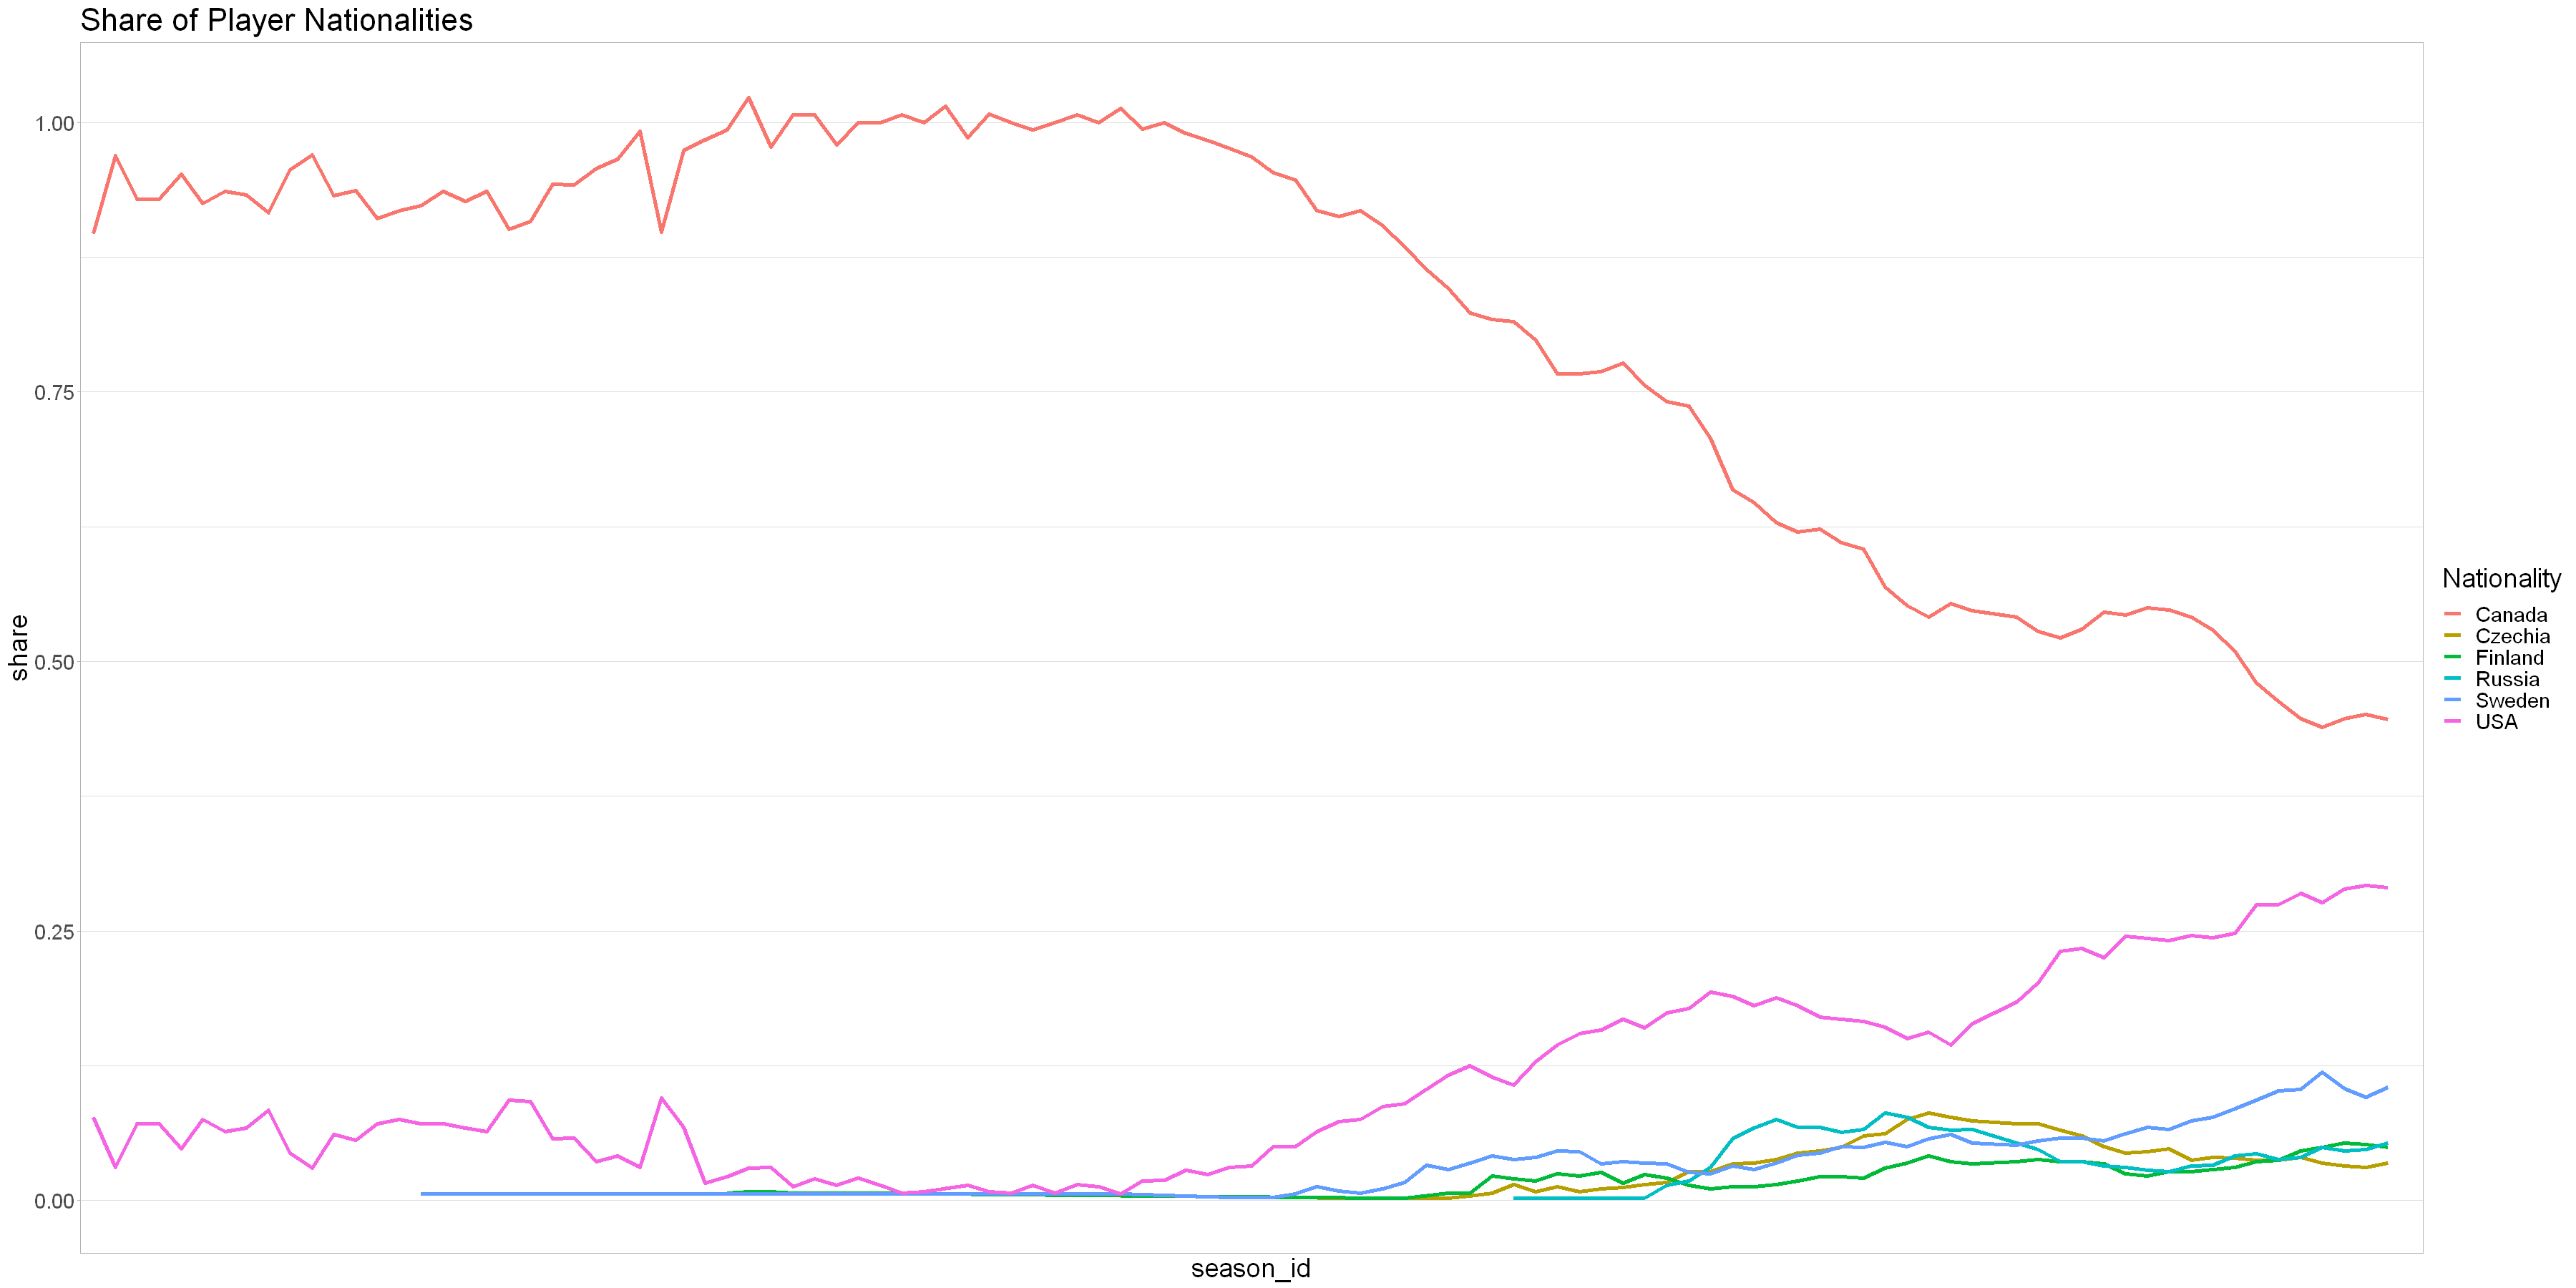

In [203]:
player_data %>%
  filter(regular_season == 1) %>%
  group_by(season_id, nationality) %>%
  summarize(n = n()) %>%
  left_join(season_regular_counts, by = "season_id") %>%
  filter(nationality %in% big_six) %>%
  mutate(share = round(n/season_n, 3)) %>%
  ggplot(., aes(x = season_id, y = share, color = nationality)) +
  geom_line(size = 1.5) + 
  labs(title = "Share of Player Nationalities", color="Nationality") +
  scale_x_discrete(breaks = 1:12, labels = 1:12) + 
  scale_fill_manual(values = my_colours) +
  def_plot_setup



Warning message:
"Removed 6 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_point()`)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot

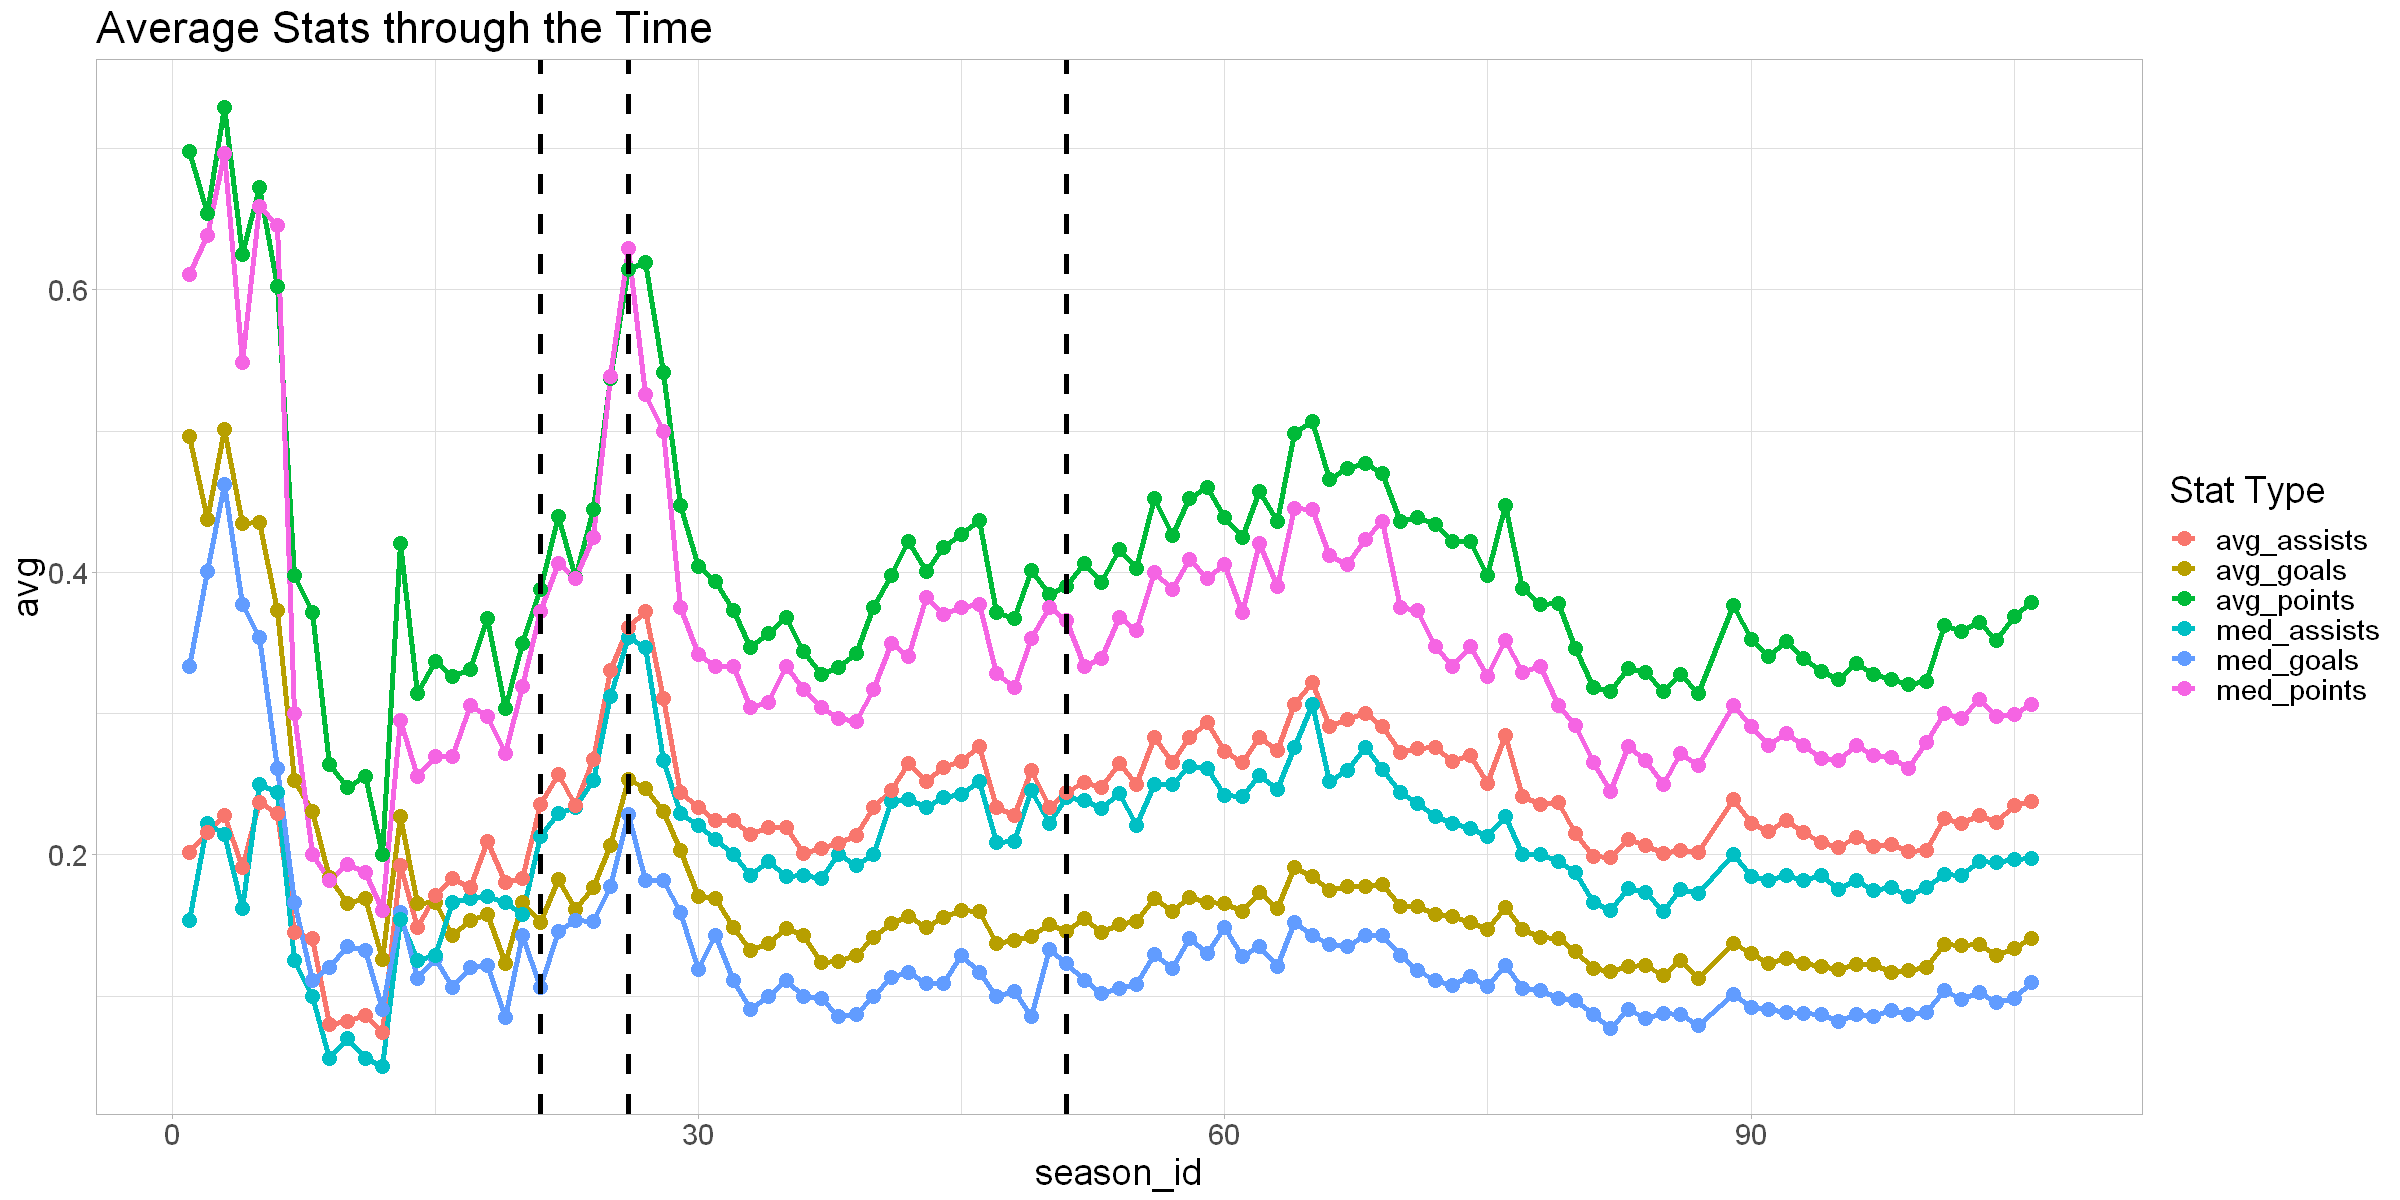

In [185]:
options(repr.plot.width=20, repr.plot.height=10)
player_data %>%
  filter(regular_season==1) %>%
  group_by(season_id) %>%
  summarize(
    avg_goals = mean(avg_g, na.rm=TRUE), 
    avg_points = mean(avg_p, na.rm=TRUE), 
    med_goals = median(avg_g, na.rm = TRUE), 
    med_points = median(avg_p, na.rm=TRUE), 
    med_assists = median(avg_a, na.rm = TRUE), 
    avg_assists = mean(avg_a, na.rm = TRUE)
    ) %>%
  pivot_longer(!season_id, names_to = "type_stat", values_to = "avg") %>%
  ggplot(., aes(x = season_id, y = avg, colour = type_stat)) +
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  labs(title= "Average Stats through the Time", color="Stat Type") +
  geom_vline(xintercept = 21, size = 1.5, linetype = "dashed") +
  geom_vline(xintercept = 26, size = 1.5, linetype = "dashed") +
  geom_vline(xintercept = 51, size = 1.5, linetype = "dashed") + 
  scale_fill_manual(values = my_colours) +
  def_plot_setup 

### Dominant Player Performances

#### Distribution of Seasonal Points Per Game

Warning message:
"Removed 1135 rows containing non-finite values (`stat_density()`)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font databas

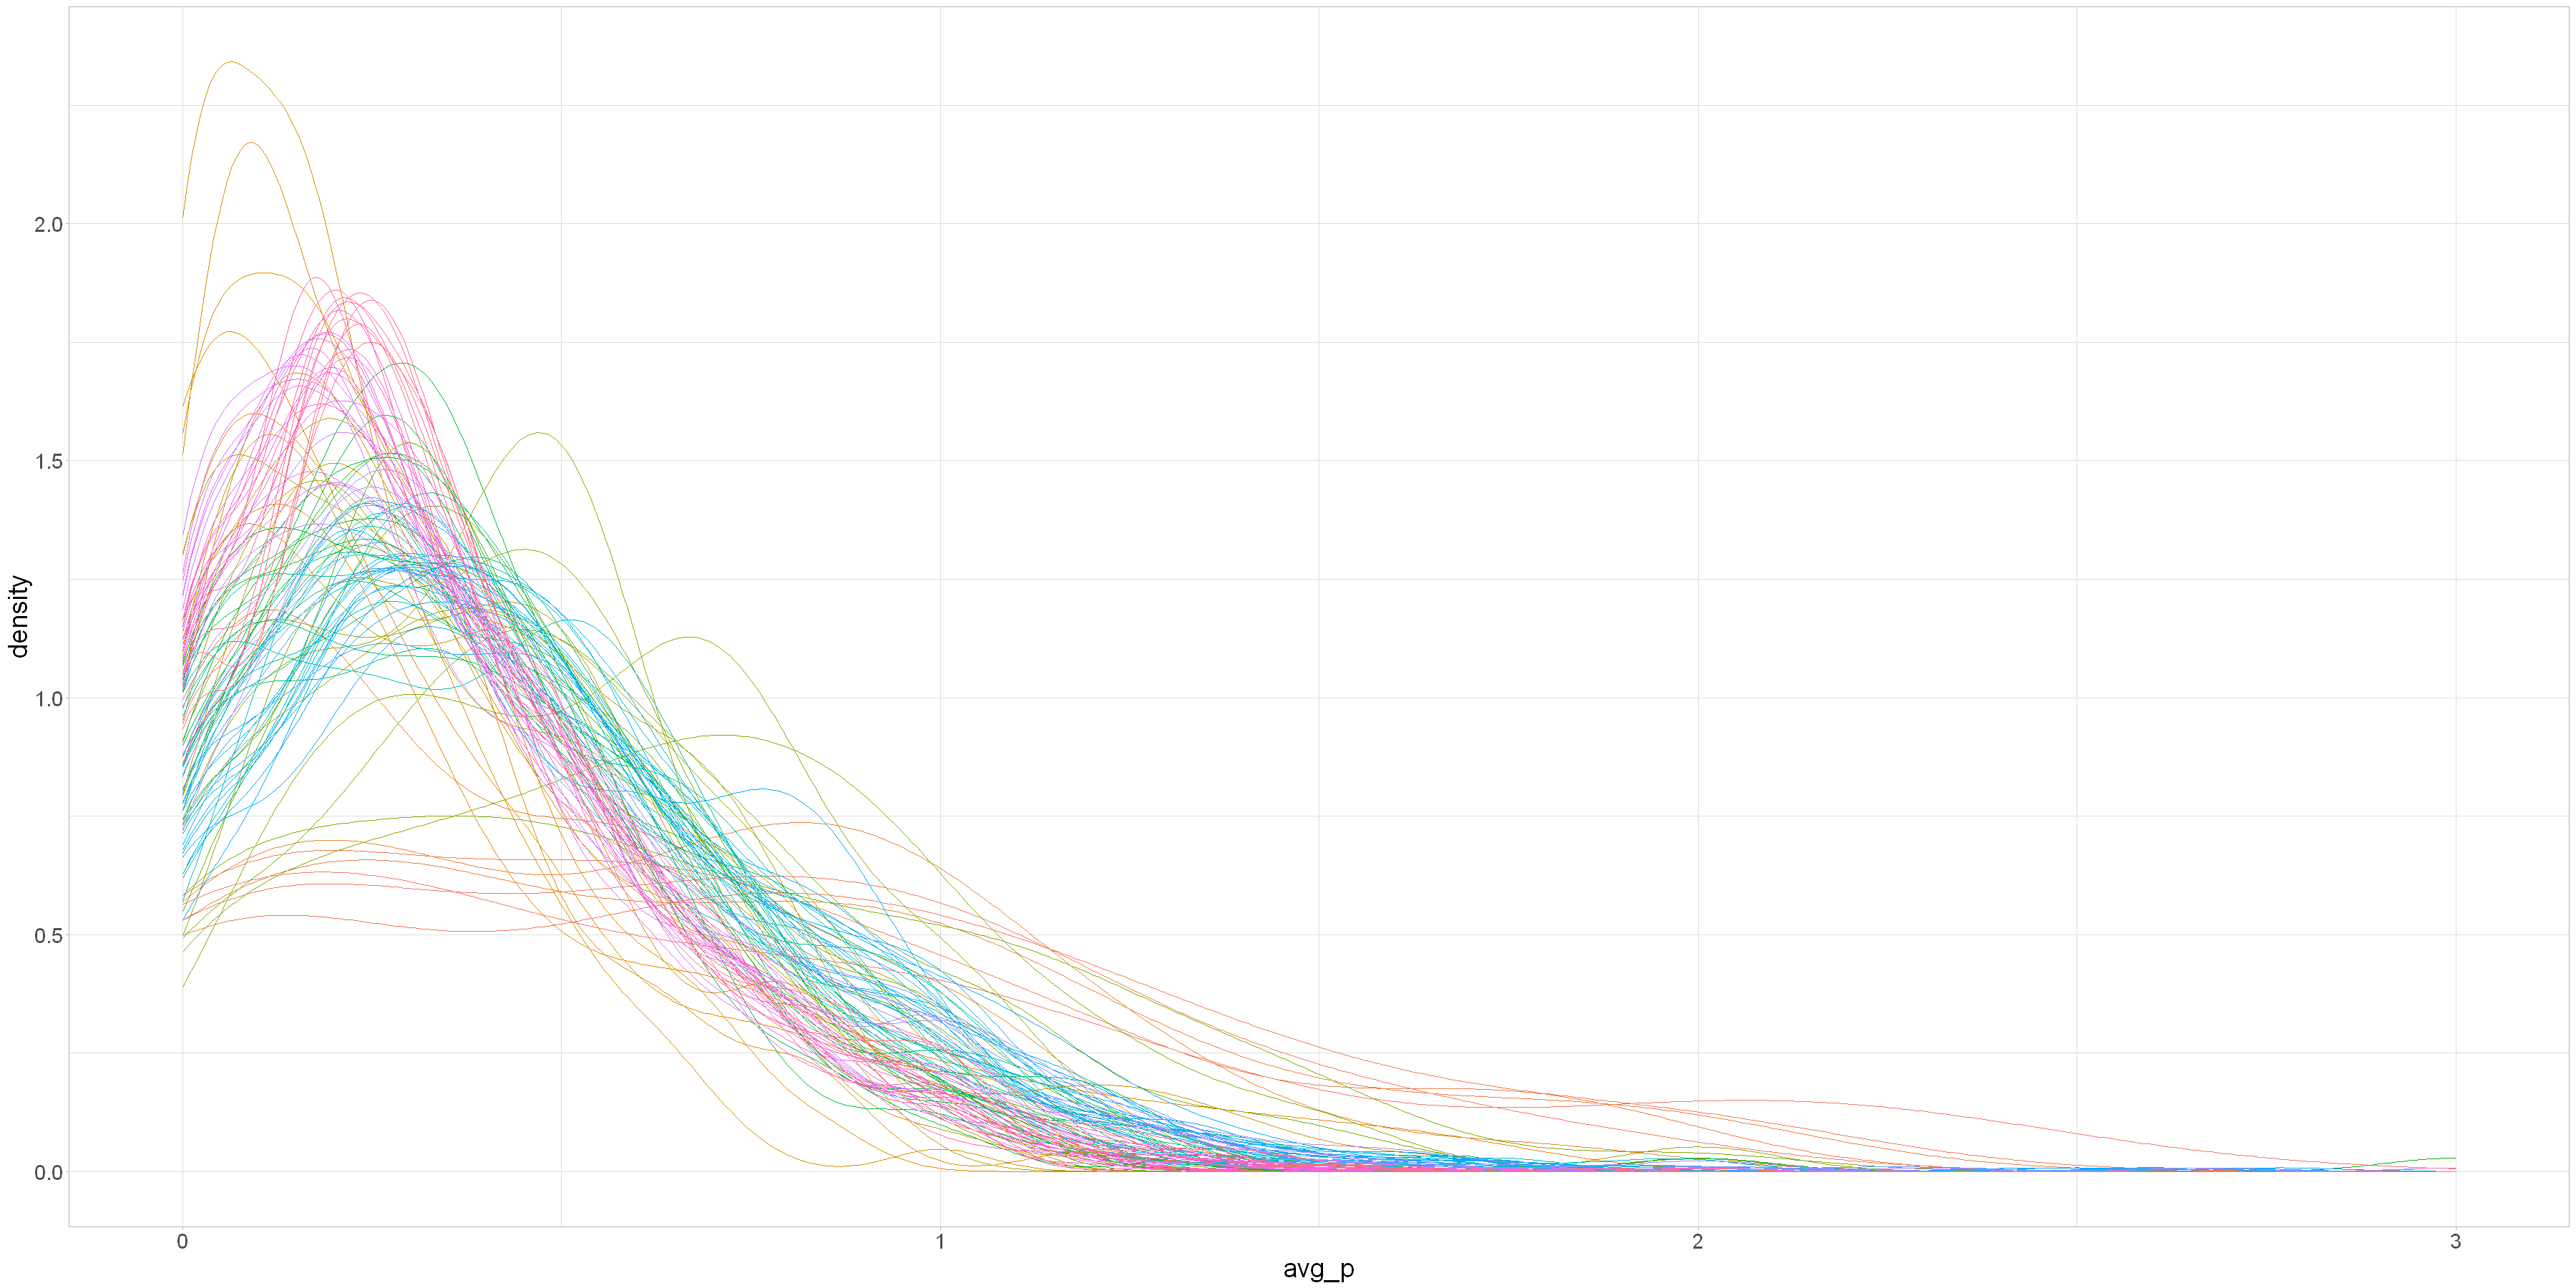

In [313]:
player_data %>%
  filter(regular_season == 1) %>%
  ggplot(., aes(x = avg_p, colour = season)) + 
  geom_density() + 
  def_plot_setup + 
  theme(legend.position = 'none') 

#### Points Per Game - Forwards

##### Best Seasons

In [373]:
dominance_p_f <- create_comparative_measure(player_data, "attack", 1, avg_p)
head(dominance_p_f, 10)

u_id,name,season_id,season,handedness,nationality,active,position,regular_season,gp,...,tp,plus_minus,pm,avg_g,avg_p,avg_a,median_games,mad,median,measure
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9679,Mario Lemieux,76,1992-1993,R,Canada,0,C,1,60,...,160,55,38,1.1500000,2.666667,1.516667,25,0.3344675,0.4755952,6.550925
9678,Wayne Gretzky,69,1985-1986,L,Canada,0,C,1,80,...,215,71,46,0.6500000,2.687500,2.037500,19,0.3363613,0.6018868,6.200514
9678,Wayne Gretzky,68,1984-1985,L,Canada,0,C,1,80,...,208,100,52,0.9125000,2.600000,1.687500,19,0.3333604,0.5887491,6.033263
9678,Wayne Gretzky,67,1983-1984,L,Canada,0,C,1,74,...,205,78,39,1.1756757,2.770270,1.594595,19,0.3695186,0.5767591,5.936132
183442,Connor McDavid,104,2020-2021,L,Canada,1,C,1,56,...,105,21,20,0.5892857,1.875000,1.285714,23,0.2471000,0.4166667,5.901794
9679,Mario Lemieux,79,1995-1996,R,Canada,0,C,1,70,...,161,10,54,0.9857143,2.300000,1.314286,24,0.3183360,0.4444444,5.828921
9678,Wayne Gretzky,65,1981-1982,L,Canada,0,C,1,80,...,212,80,26,1.1500000,2.650000,1.500000,17,0.3619798,0.6388889,5.555865
9678,Wayne Gretzky,66,1982-1983,L,Canada,0,C,1,80,...,196,61,59,0.8875000,2.450000,1.562500,19,0.3403707,0.5844156,5.481037
9679,Mario Lemieux,72,1988-1989,R,Canada,0,C,1,76,...,199,41,100,1.1184211,2.618421,1.500000,19,0.3818818,0.5613097,5.386775


##### Career Highs

In [205]:
career_p_dominance_f <- create_career_measure(dominance_p_f)
head(career_p_dominance_f, 10)

name,measure,n
<chr>,<dbl>,<int>
Mario Lemieux,4.621503,11
Connor McDavid,4.536532,8
Wayne Gretzky,4.277086,19
Leon Draisaitl,3.361789,9
Nikita Kucherov,3.165402,8
Sidney Crosby,3.131641,14
Peter Forsberg,3.076102,7
Yevgeni Malkin,3.068862,12
Auston Matthews,3.050040,7


[1] 0
[1] 20
[1] 20
[1] 40
[1] 40
[1] 60
[1] 60
[1] 80
[1] 80
[1] 100
[1] 100
[1] 106


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in Post

$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

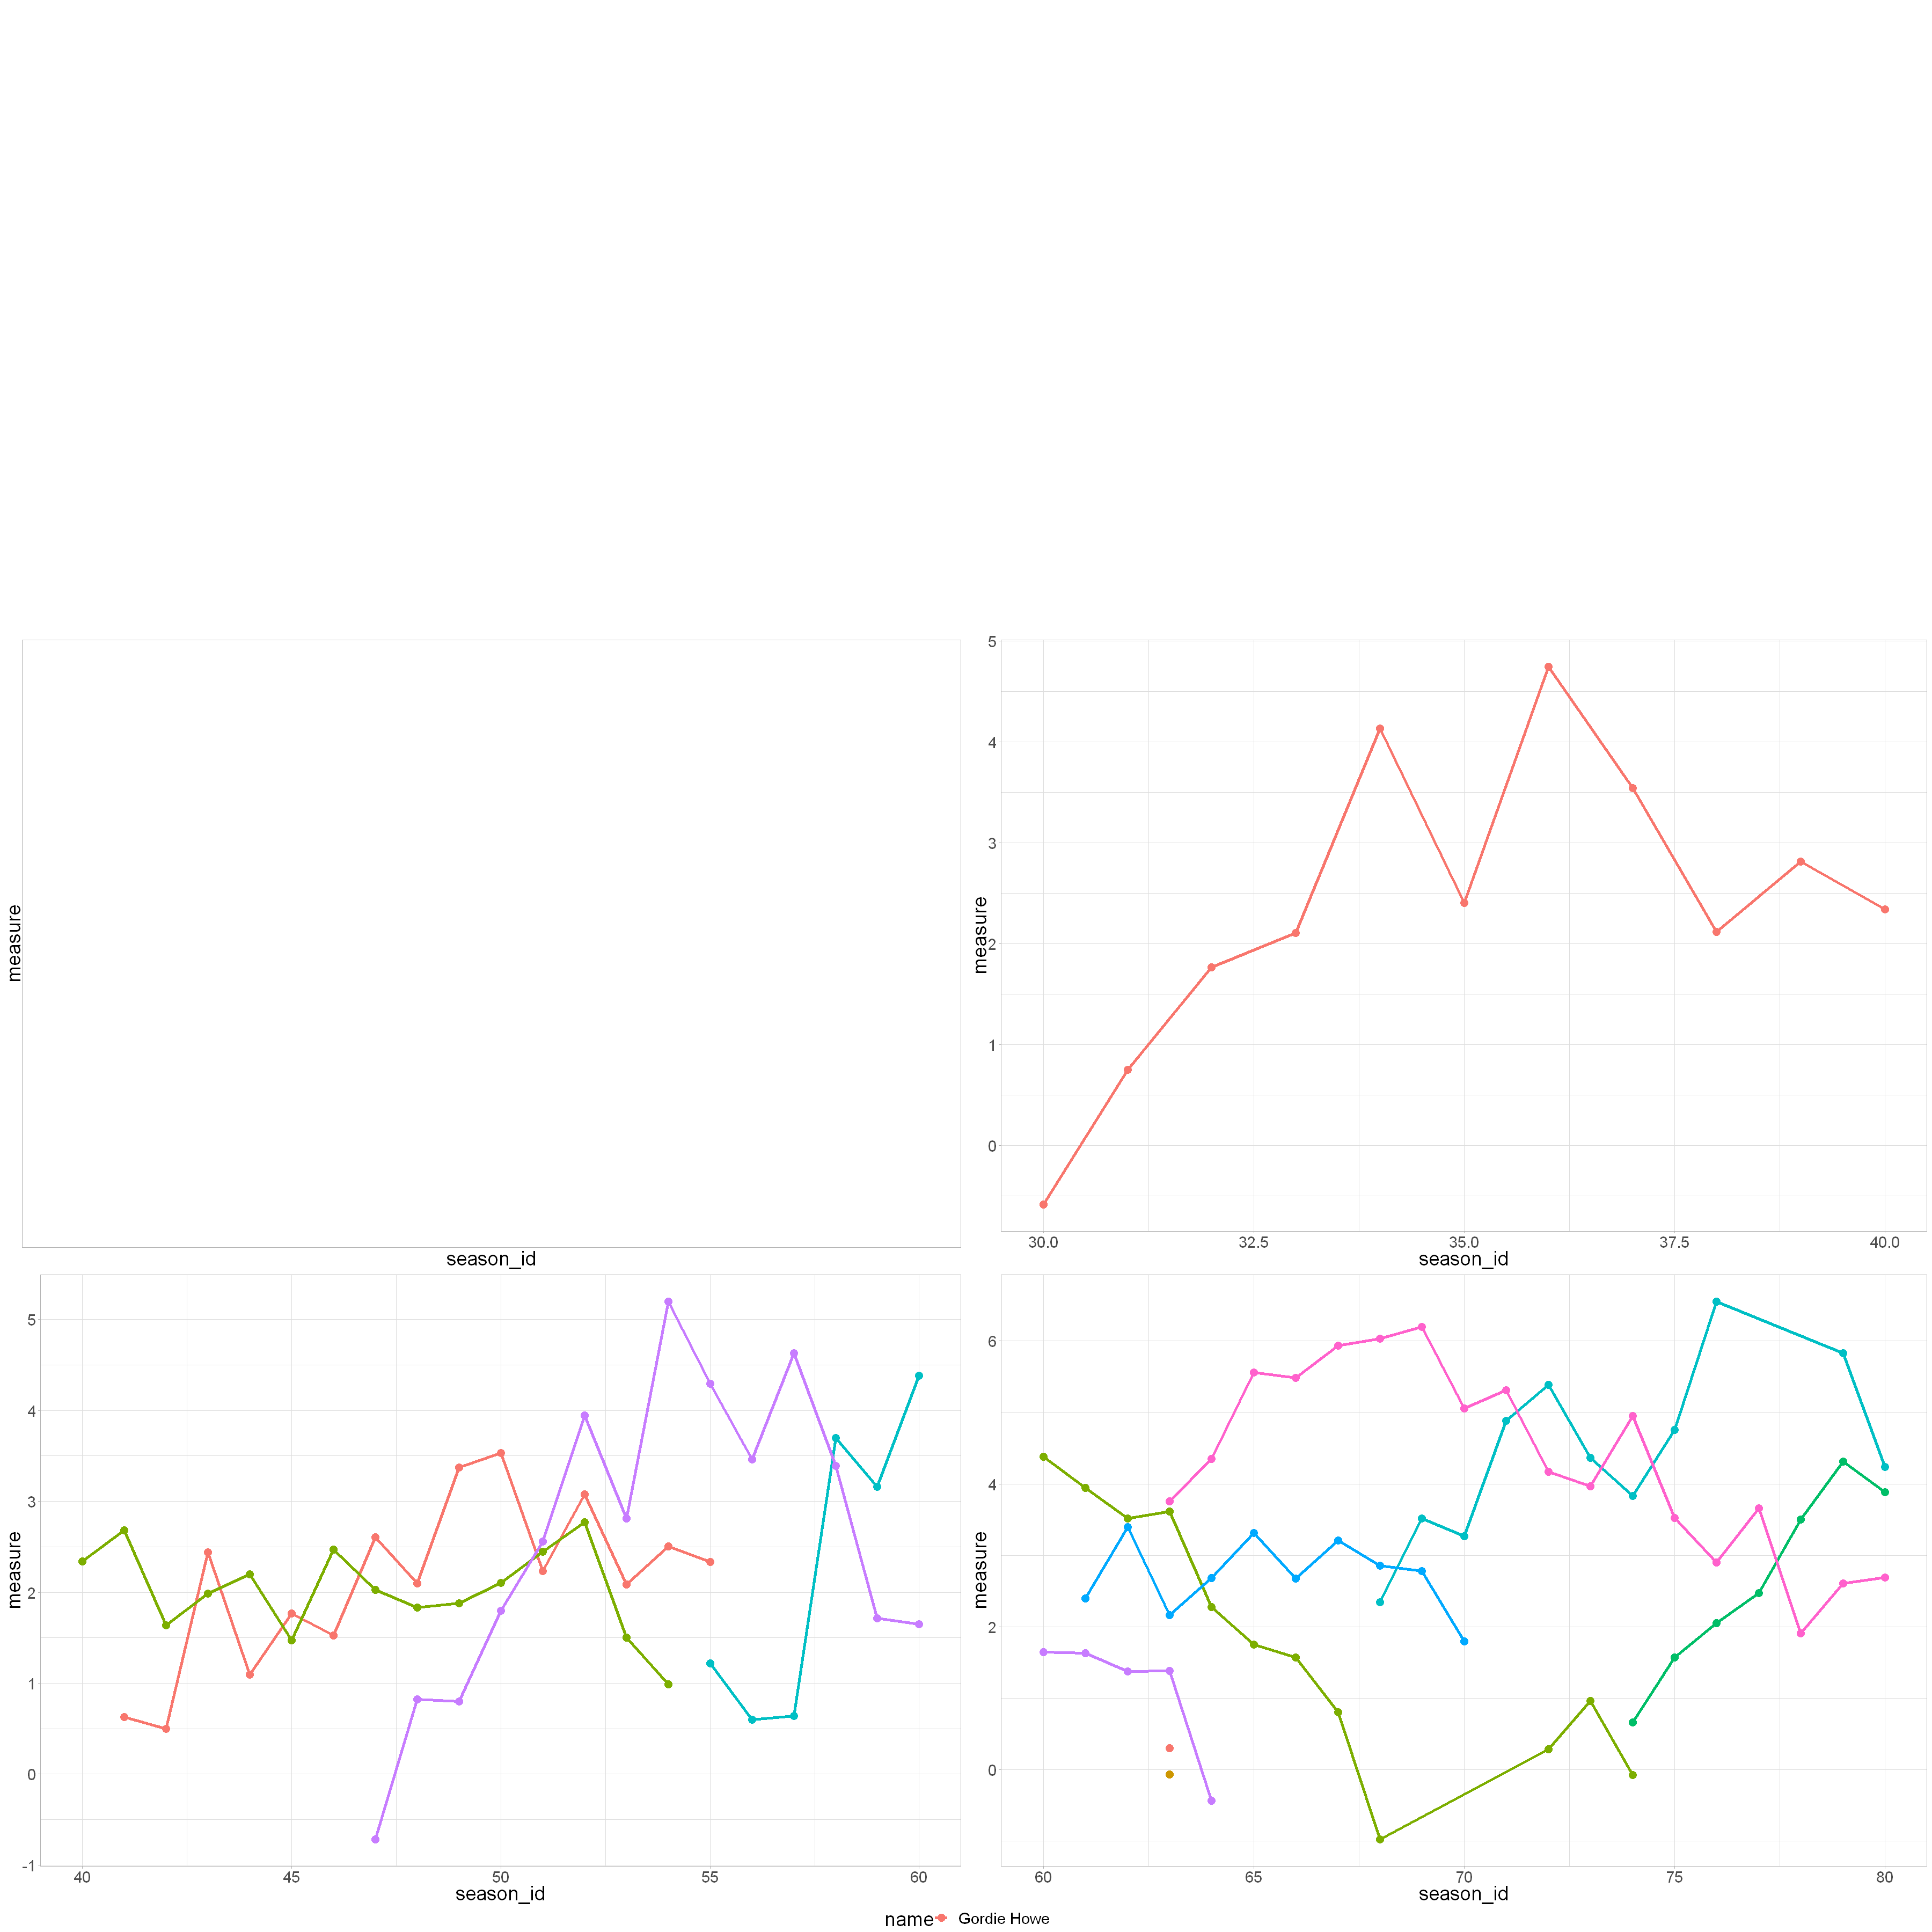

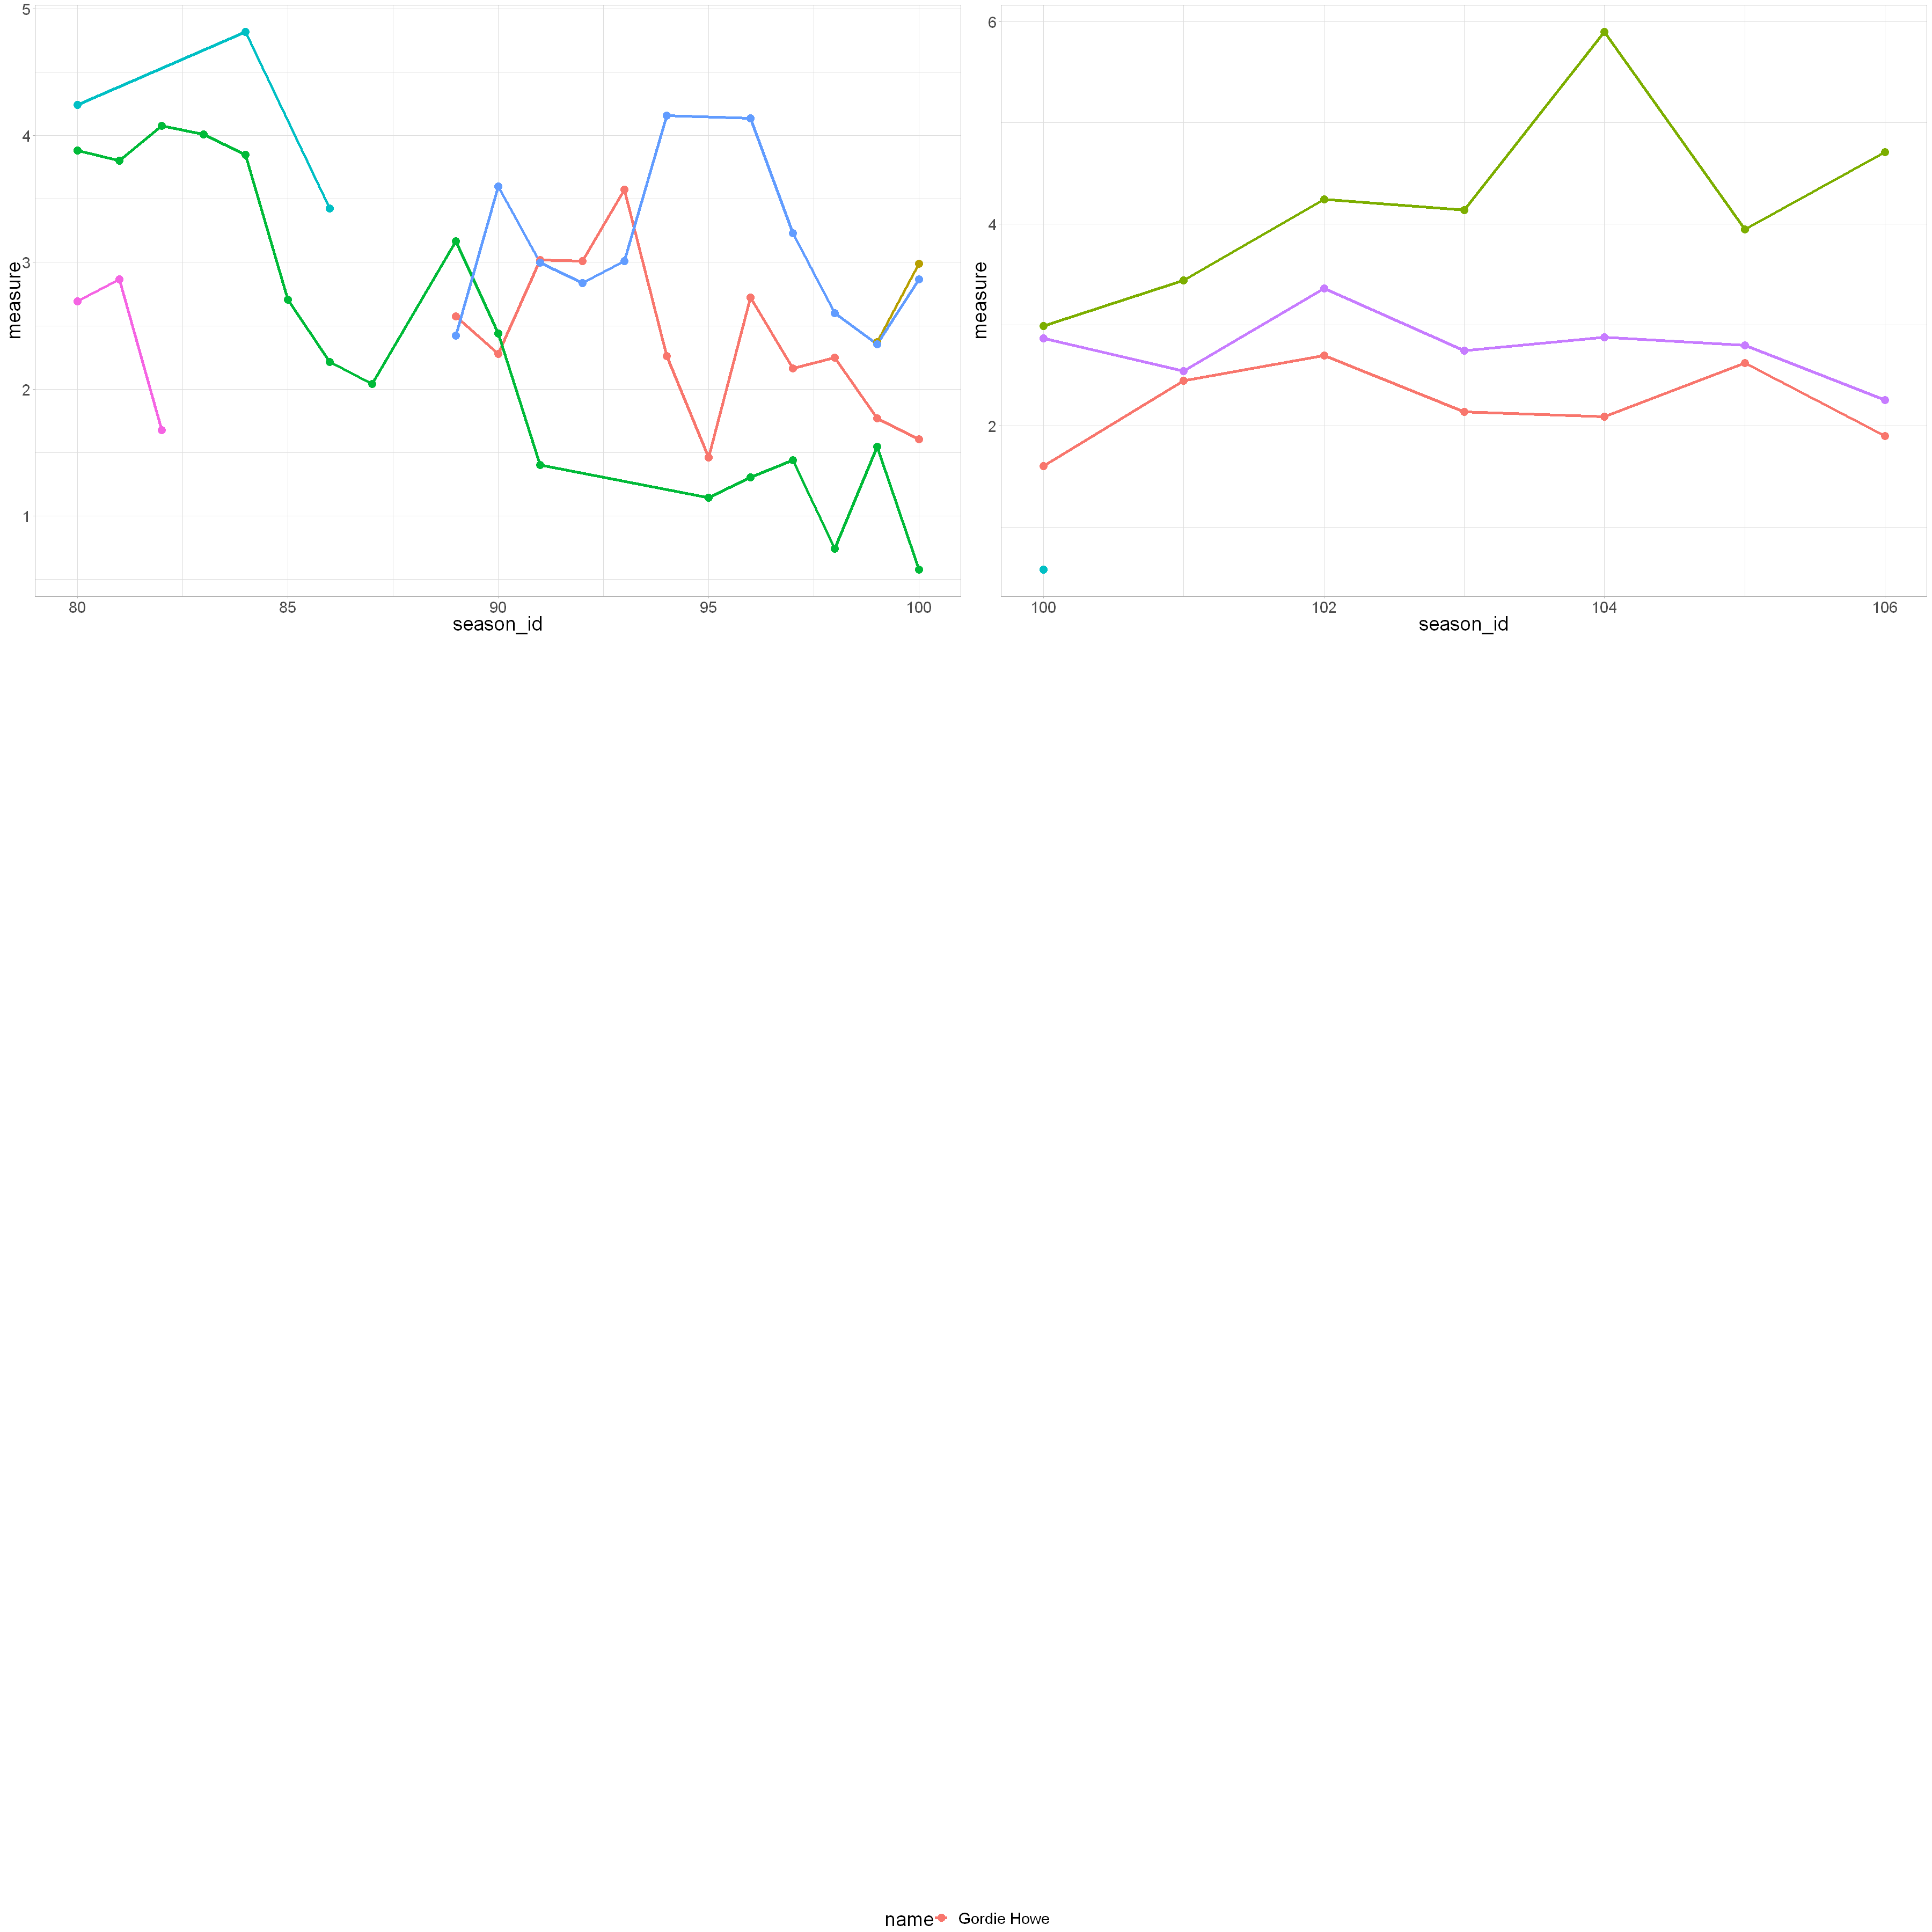

In [411]:
options(repr.plot.width = 30, repr.plot.height = 30)
 season_ids <- c(seq(0, 106,20), 106)
 list_plots <- list()
for (ind in 1:(length(season_ids) - 1)) {
  min <- season_ids[ind]
  max <- season_ids[ind + 1]
  plot_period <- create_comparison_plot(dominance_p_f, "forward", "ppg",  forward_legends, min=min, max=max)
  list_plots[[ind]] <- plot_period
} 
ggarrange(plotlist=list_plots, common.legend = TRUE, legend="bottom",  width = 10, height = 10, ncol=2, nrow=3)  


#### Distribution of Seasonal Goals per Game

Warning message:
"Removed 21 rows containing non-finite values (`stat_density()`)."


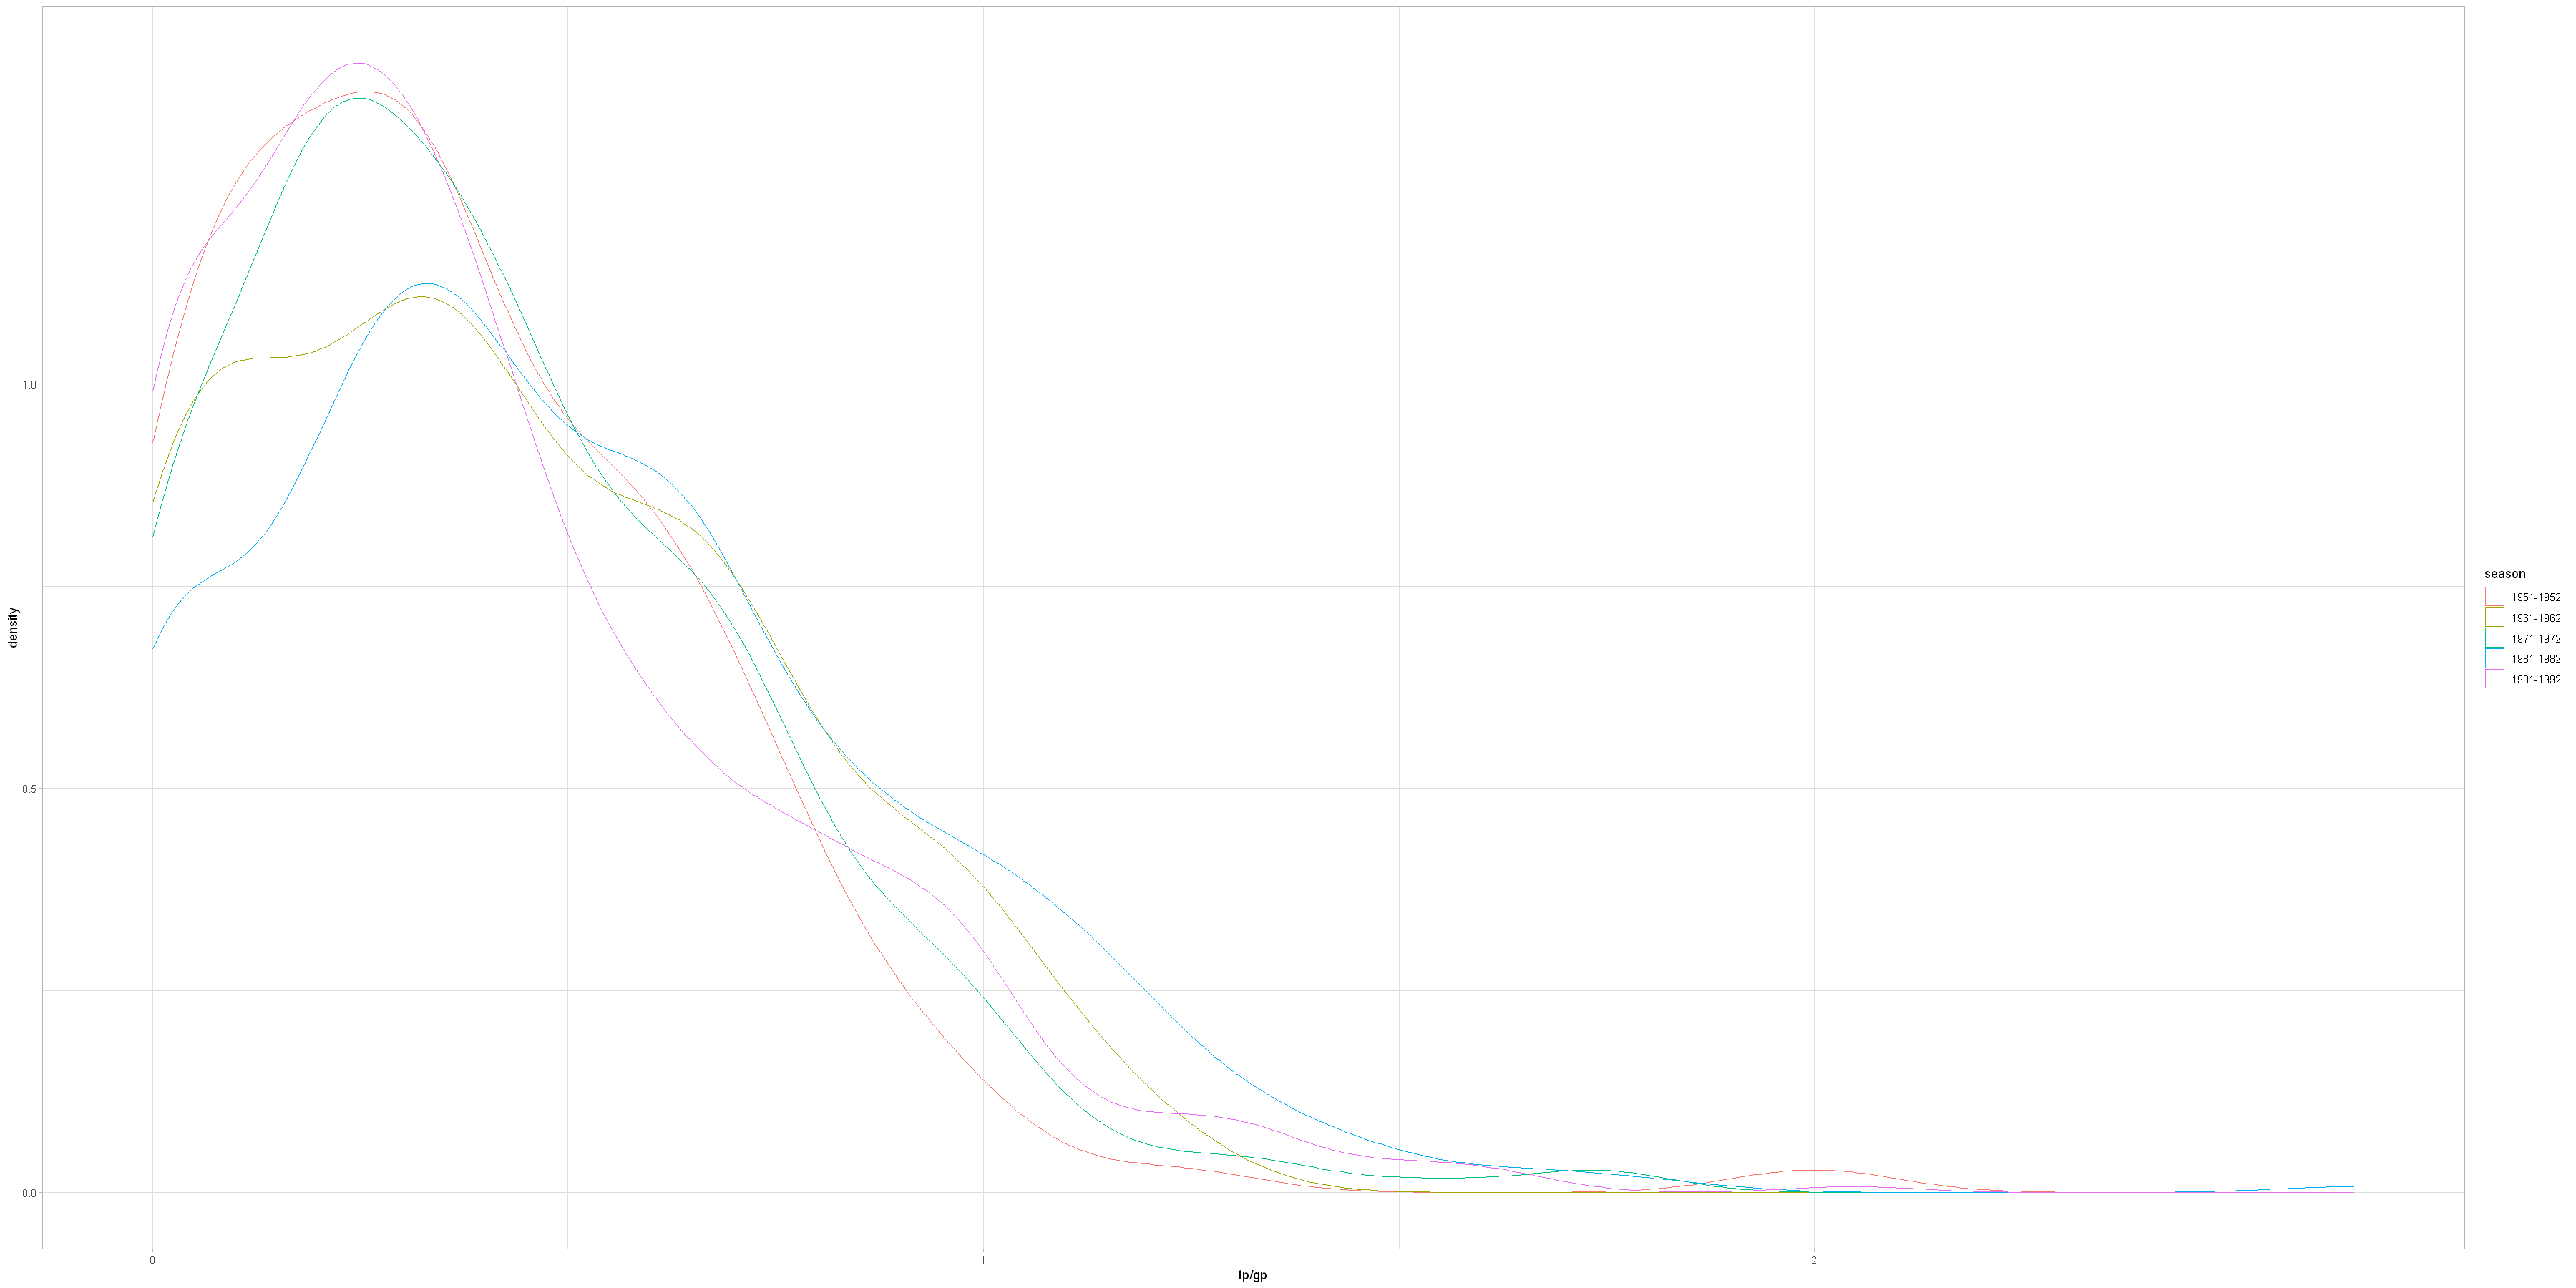

In [236]:
data %>%
  filter(regular_season == 1) %>%
  filter(season_id %in% c(35, 45, 55, 65, 75)) %>%
  ggplot(., aes(x = tp/gp, colour=season)) + 
  geom_density() + 
  theme_light()

#### Goals Per Game - Forwards

##### Best Seasons

In [208]:
dominance_g_f <- create_comparative_measure(player_data, "attack", 1, avg_g)
head(dominance_g_f, 10)


Adding missing grouping variables: `u_id`, `handedness`


rank,u_id,handedness,name,position,active,gp,g,a,tp,...,season,nationality,avg_p,avg_g,avg_a,mad,median,median_games,measure,season_id
<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,9679,R,Mario Lemieux,C,0,60,69,91,160,...,1992-1993,Canada,2.666667,1.1500000,1.5166667,0.1479732,0.1636364,60.0,6.665825,76
2,9678,L,Wayne Gretzky,C,0,74,87,118,205,...,1983-1984,Canada,2.770270,1.1756757,1.5945946,0.1709046,0.2013514,59.0,5.700985,67
3,21341,R,Brett Hull,RW,0,78,86,45,131,...,1990-1991,USA,1.679487,1.1025641,0.5769231,0.1638399,0.1694915,53.0,5.695028,74
4,9679,R,Mario Lemieux,C,0,70,69,92,161,...,1995-1996,Canada,2.300000,0.9857143,1.3142857,0.1477781,0.1538462,59.5,5.629170,79
5,54041,R,Babe Dye,RW,0,29,38,8,46,...,1924-1925,Canada,1.586207,1.3103448,0.2758621,0.2081483,0.1403941,27.0,5.620756,8
6,21327,L,Alexander Mogilny,RW,0,77,76,51,127,...,1992-1993,Russia,1.649351,0.9870130,0.6623377,0.1479732,0.1636364,60.0,5.564362,76
7,9679,R,Mario Lemieux,C,0,76,85,114,199,...,1988-1989,Canada,2.618421,1.1184211,1.5000000,0.1730197,0.1690141,55.0,5.487276,72
8,2683,R,Teemu Selänne,RW,0,84,76,56,132,...,1992-1993,Finland,1.571429,0.9047619,0.6666667,0.1479732,0.1636364,60.0,5.008511,76
9,21341,R,Brett Hull,RW,0,73,70,39,109,...,1991-1992,USA,1.493151,0.9589041,0.5342466,0.1645461,0.1515152,49.0,4.906763,75


##### Highest Career Averages

In [211]:
career_g_dominance_f <- create_career_measure(dominance_g_f)
head(career_g_dominance_f, 20)

name,measure,n
<chr>,<dbl>,<int>
Mario Lemieux,3.887398,11
Auston Matthews,3.603447,7
Alexander Ovechkin,3.403717,19
Mike Bossy,3.273595,10
Pavel Bure,3.254599,9
David Pastrnak,3.007571,8
Connor McDavid,2.980707,8
Brett Hull,2.845860,16
Eric Lindros,2.813720,8


##### Best Players Carreer Comparison

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

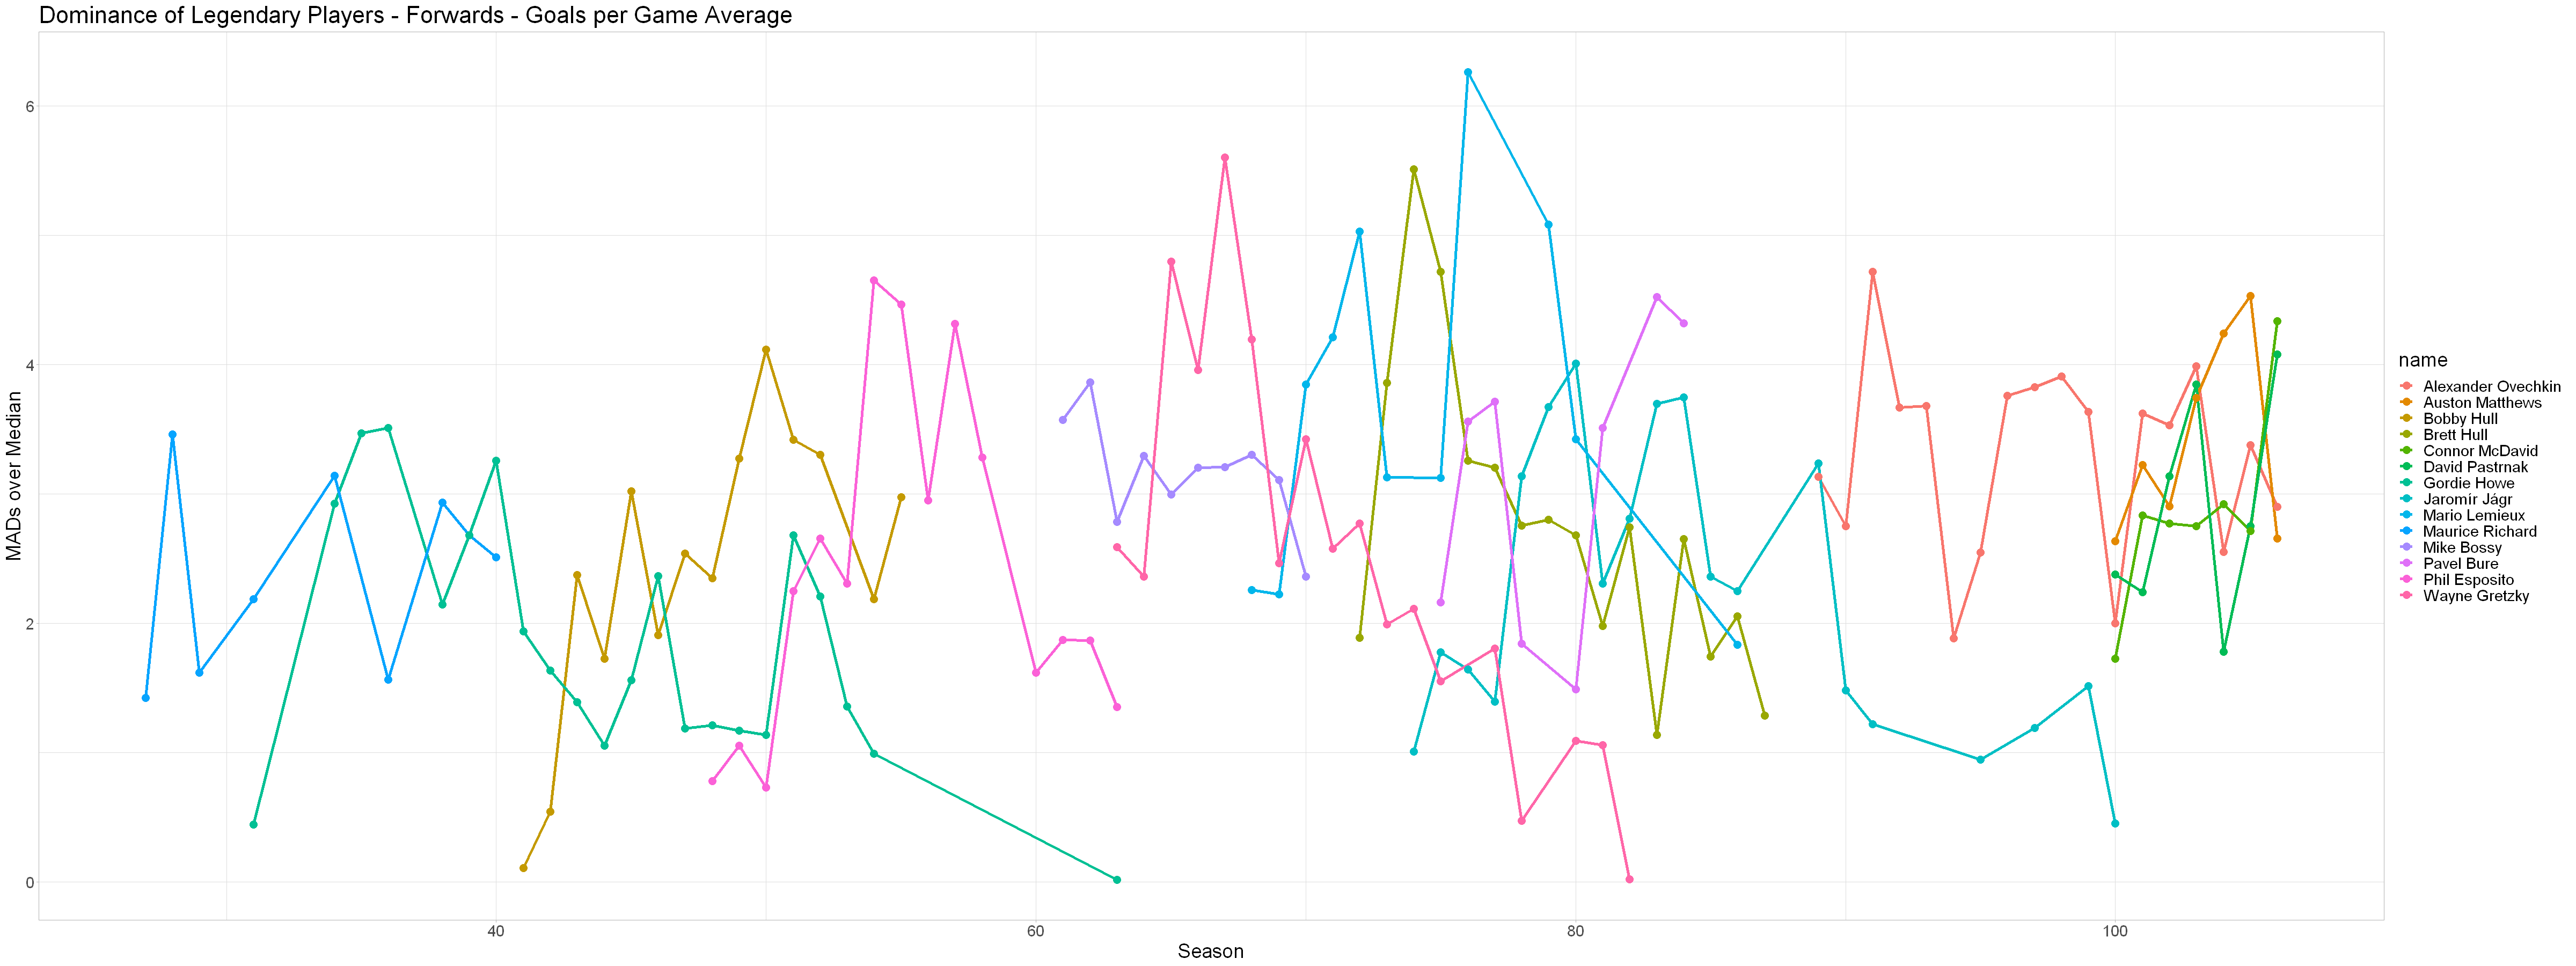

In [90]:
options(repr.plot.width = 40, repr.plot.height = 15)
forward_legends <- c("Mario Lemieux", "Wayne Gretzky", "Gordie Howe", "Connor McDavid", "Pavel Bure", 
"David Pastrnak", "Mike Bossy", "Phil Esposito", "Bobby Hull", "Alexander Ovechkin", "Brett Hull", "Maurice Richard", 
"Jaromír Jágr", "Auston Matthews")
dominance_g_f %>%
  filter(name %in% forward_legends) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title="Dominance of Legendary Players - Forwards - Goals per Game Average", 
    y="MADs over Median", 
    x="Season"
  ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4)  + 
  def_plot_setup 

#### Points Per Game - Defenders

##### Best Seasons

In [93]:
dominance_p_d <- create_comparative_measure(player_data, "defense", 1, avg_p)
head(dominance_p_d, 20)

rank,name,position,active,gp,g,a,tp,plus_minus,season,team_id,nationality,avg_p,avg_g,mad,median,median_games,measure,season_id
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bobby Orr,D,0,74,32,90,122,84,1973-1974,137,Canada,1.648649,0.4324324,0.1684773,0.2500000,60.0,8.301705,57
2,Bobby Orr,D,0,63,29,72,101,56,1972-1973,137,Canada,1.603175,0.4603175,0.1742705,0.2500000,62.5,7.764793,56
3,Bobby Orr,D,0,80,46,89,135,80,1974-1975,137,Canada,1.687500,0.5750000,0.1824738,0.2773504,59.0,7.727954,58
4,Bobby Orr,D,0,76,33,87,120,54,1969-1970,137,Canada,1.578947,0.4342105,0.1820737,0.2118590,56.0,7.508435,53
5,Bobby Orr,D,0,78,37,102,139,124,1970-1971,137,Canada,1.782051,0.4743590,0.2182182,0.2380952,57.0,7.075286,54
6,Dit Clapper,D/F,0,44,41,20,61,NA,1929-1930,137,Canada,1.386364,0.9318182,0.1762178,0.1975610,39.5,6.746212,13
7,Erik Karlsson,D,1,82,25,76,101,-26,2022-2023,55,Sweden,1.231707,0.3048780,0.1520615,0.2307692,46.0,6.582454,106
8,Bobby Orr,D,0,76,37,80,117,86,1971-1972,137,Canada,1.539474,0.4868421,0.2188461,0.2241852,54.5,6.010107,55
9,Cale Makar,D,1,60,17,49,66,16,2022-2023,5137,Canada,1.100000,0.2833333,0.1520615,0.2307692,46.0,5.716309,106


##### Highest Career Averages

In [212]:
career_p_dominance_d <- create_career_measure(dominance_p_d)
head(career_p_dominance_d, 10)

name,measure,n
<chr>,<dbl>,<int>
Bobby Orr,6.316375,8
Cale Makar,4.663912,4
Paul Coffey,3.960283,15
Quinn Hughes,3.656036,4
Raymond Bourque,3.495245,21
Erik Karlsson,3.481266,13
Brian Leetch,3.440680,13
Adam Fox,3.433012,4
Al MacInnis,3.364472,17


##### Comaprison of Legendary Players

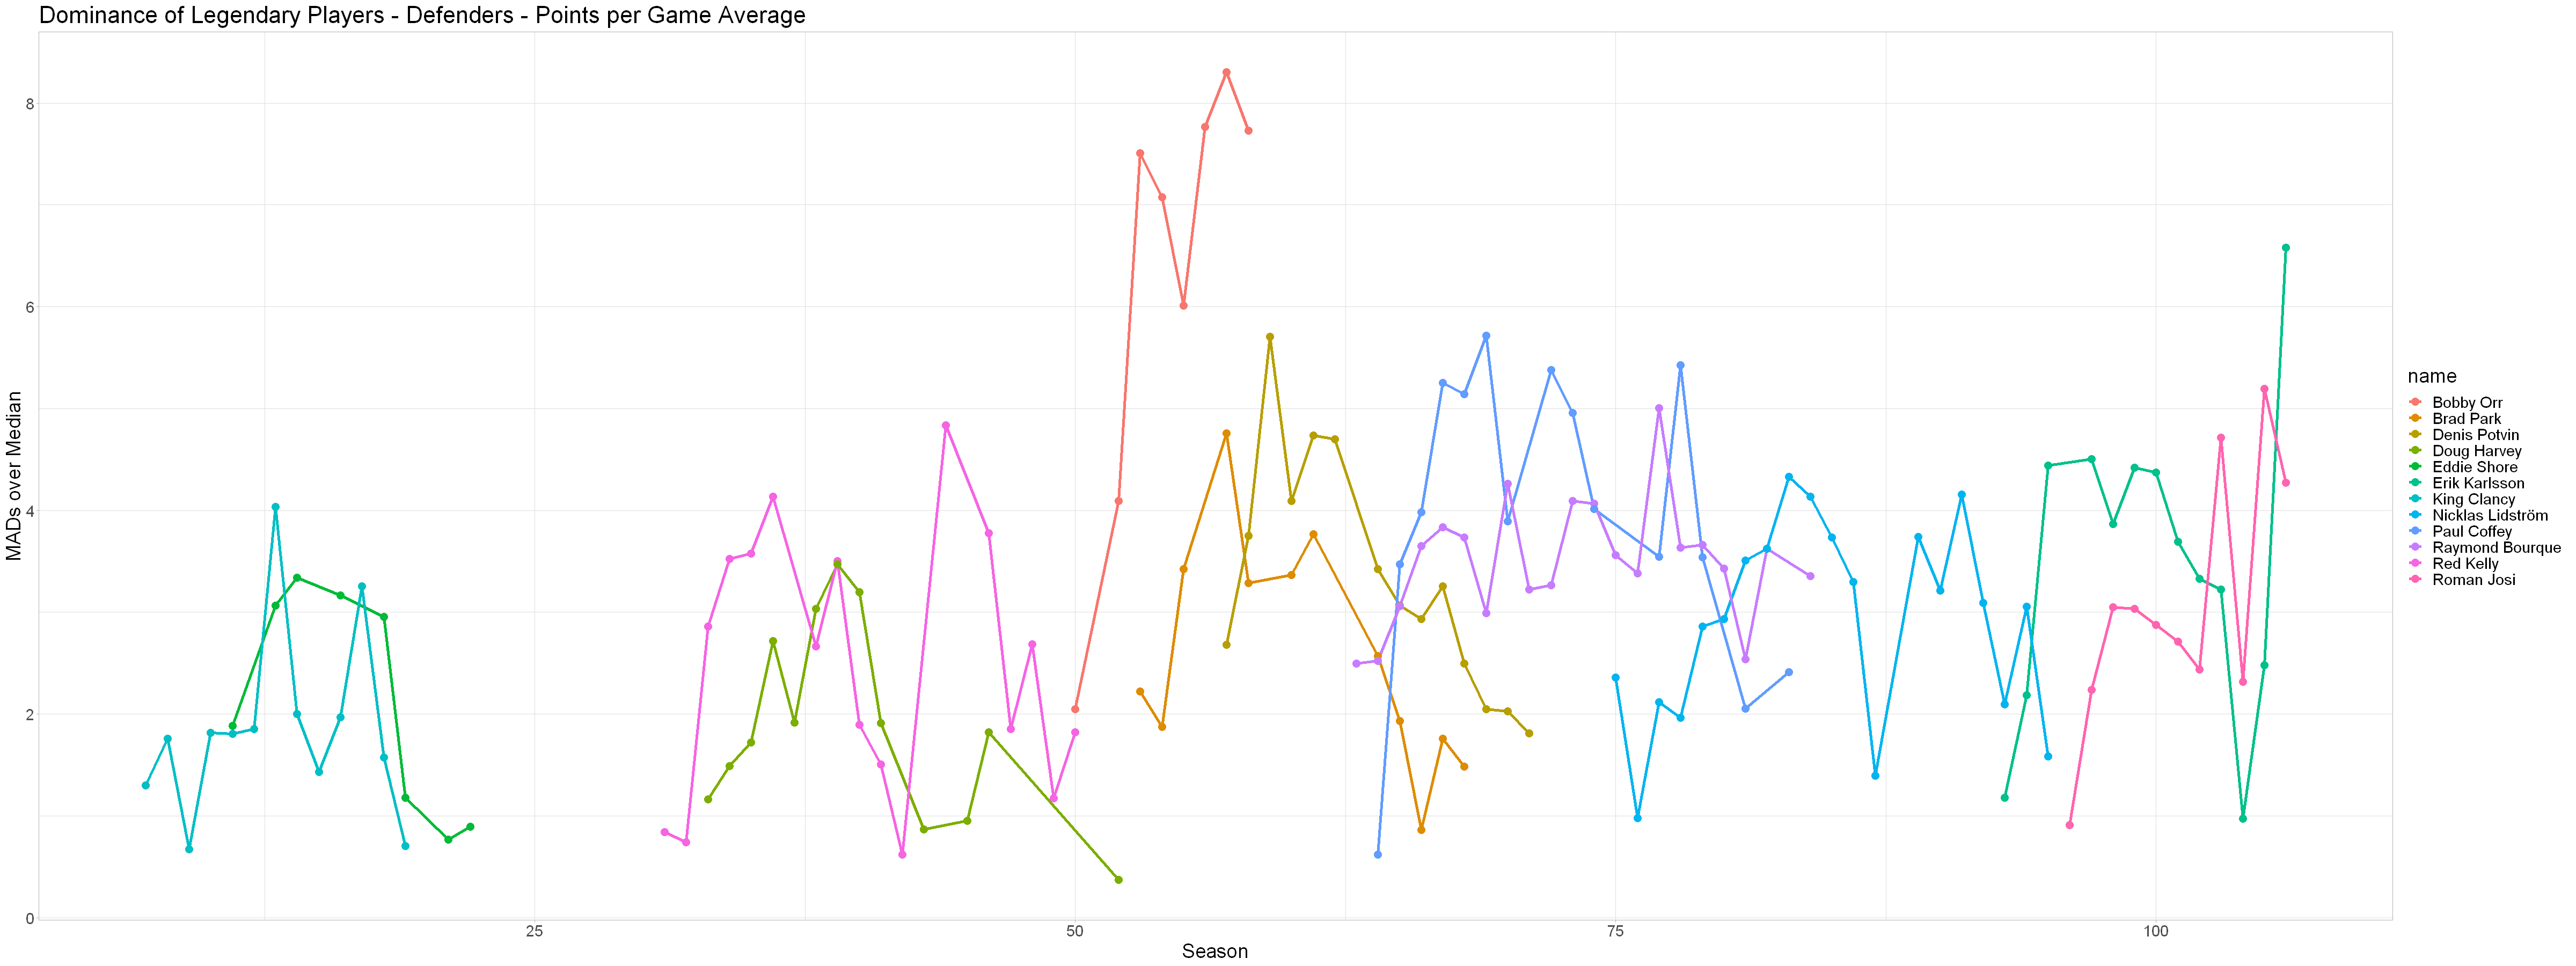

In [227]:
options(repr.plot.width = 40, repr.plot.height = 15)
defense_legends <- c("Bobby Orr", "Paul Coffey", "Raymond Bourque", "Erik Karlsson", "Denis Potvin", "Roman Josi", "Red Kelly", "Nicklas Lidström", "Doug Harvey", "King Clancy", "Eddie Shore", "Brad Park")
dominance_p_d %>%
  filter(name %in% defense_legends) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title = "Dominance of Legendary Players - Defenders - Points per Game Average", 
    y = "MADs over Median", 
    x = "Season"
  ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  def_plot_setup 

#### Goals Per Game - Defenders

##### Best Seasons

In [95]:
dominance_g_d <- create_comparative_measure(player_data, "defense", 1, avg_g)
head(dominance_g_d, 20)

rank,name,position,active,gp,g,a,tp,plus_minus,season,team_id,nationality,avg_p,avg_g,mad,median,median_games,measure,season_id
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Doug Mohns,LW/D,0,70,22,27,49,NA,1965-1966,163,Canada,0.7000000,0.3142857,0.02316562,0.01562500,46.0,12.892409,49
2,Dit Clapper,D/F,0,44,41,20,61,NA,1929-1930,137,Canada,1.3863636,0.9318182,0.07990636,0.08001422,39.5,10.660027,13
3,Bobby Orr,D,0,76,33,87,120,54,1969-1970,137,Canada,1.5789474,0.4342105,0.04266696,0.02877847,56.0,9.502249,53
4,Sergei Gonchar,D,0,53,21,10,31,1,1998-1999,39,Russia,0.5849057,0.3962264,0.04061918,0.02739726,46.0,9.080173,82
5,Bobby Orr,D,0,80,46,89,135,80,1974-1975,137,Canada,1.6875000,0.5750000,0.06177500,0.04166667,59.0,8.633482,58
6,Dit Clapper,D/F,0,48,17,8,25,NA,1936-1937,137,Canada,0.5208333,0.3541667,0.03901579,0.02631579,39.0,8.403031,20
7,Mike Green,D,0,68,31,42,73,24,2008-2009,39,Canada,1.0735294,0.4558824,0.05202105,0.03508772,52.0,8.088930,92
8,Bobby Orr,D,0,76,37,80,117,86,1971-1972,137,Canada,1.5394737,0.4868421,0.05816354,0.03923077,54.5,7.695738,55
9,Baldy Northcott,D/LW,0,46,15,14,29,NA,1936-1937,145,Canada,0.6304348,0.3260870,0.03901579,0.02631579,39.0,7.683330,20


##### Highest Career Averages

In [268]:
career_g_dominance_d <- create_career_measure(dominance_g_d)
head(career_g_dominance_d, 10)

name,measure,n
<chr>,<dbl>,<int>
Bobby Orr,6.568746,8
Baldy Northcott,3.798623,9
Paul Coffey,3.687214,15
Red Kelly,3.616186,17
Denis Potvin,3.569438,14
Dit Clapper,3.466639,15
Al MacInnis,3.302296,17
Doug Mohns,3.281146,17
Guy Lapointe,3.234358,8


##### Comparison of Legendary Players

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

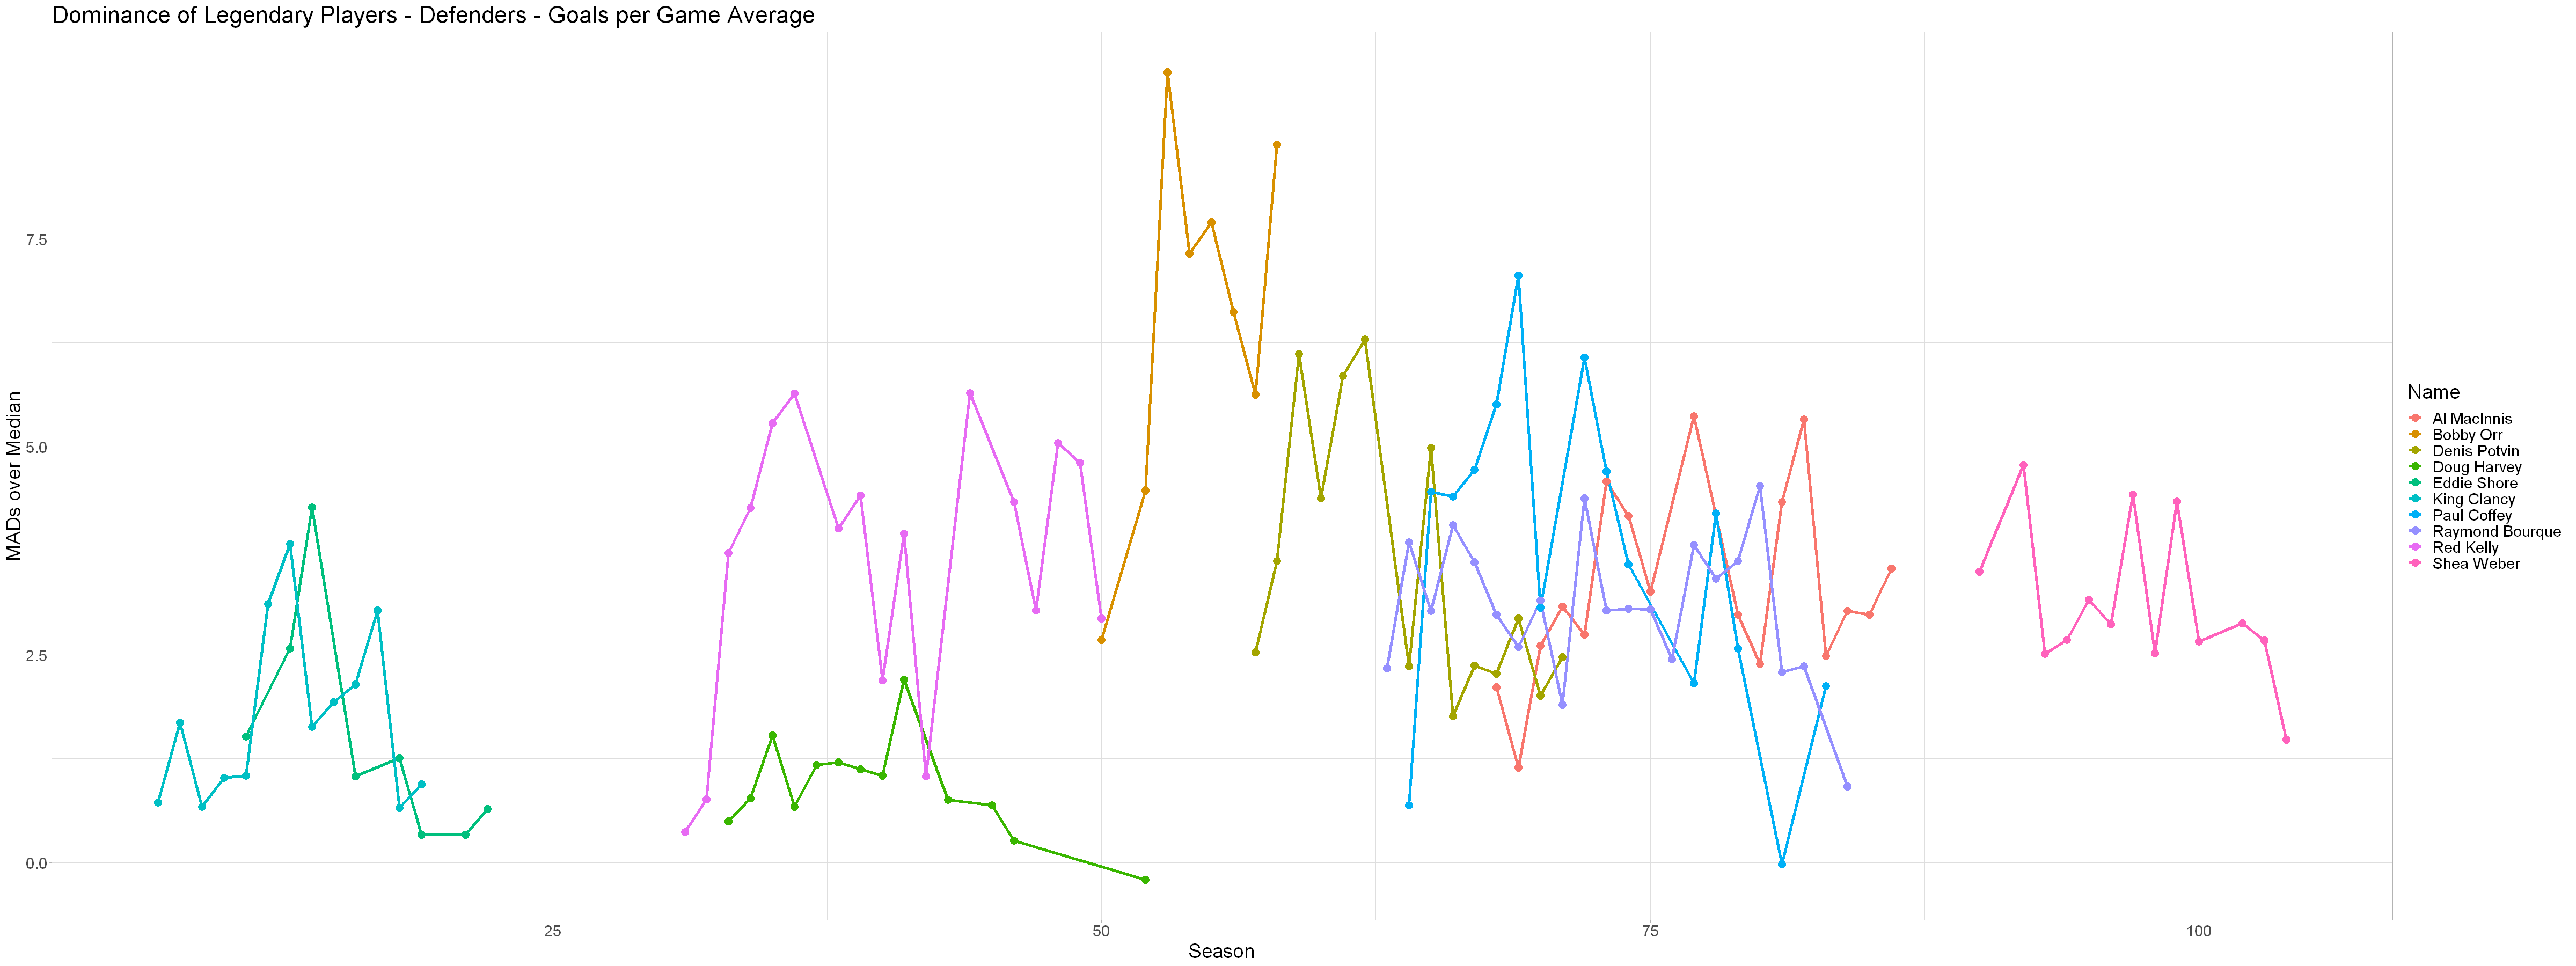

In [274]:
options(repr.plot.width = 40, repr.plot.height = 15)
defense_legends <- c("Bobby Orr", "Paul Coffey", "Raymond Bourque", "Shea Weber", "Denis Potvin", "Al MacInnis", "Red Kelly", "Doug Harvey", "King Clancy", "Eddie Shore")
dominance_g_d %>%
  filter(name %in% defense_legends) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title = "Dominance of Legendary Players - Defenders - Goals per Game Average", 
    y = "MADs over Median", 
    x = "Season", 
    colour = "Name"
  ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  def_plot_setup 

#### Plus Minus - Defenders

##### Best Seasons

In [288]:
dominance_ps_d <- create_comparative_measure(player_data, "defense", 1, plus_minus)
head(dominance_ps_d, 10)

Adding missing grouping variables: `u_id`, `handedness`


rank,u_id,handedness,name,position,active,gp,g,a,tp,...,season,nationality,avg_p,avg_g,avg_a,mad,median,median_games,measure,season_id
<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19145,L,Bobby Orr,D,0,78,37,102,139,...,1970-1971,Canada,1.7820513,0.47435897,1.3076923,13.3434,-1,63.0,9.367927,54
2,22126,L,Mark Howe,D,0,77,24,58,82,...,1985-1986,USA,1.0649351,0.31168831,0.7532468,10.3782,-1,54.5,8.286601,69
3,23533,L,Larry Robinson,D,0,77,19,66,85,...,1976-1977,Canada,1.1038961,0.24675325,0.8571429,14.8260,-2,60.0,8.228787,60
4,32217,L,Brad McCrimmon,D,0,80,13,43,56,...,1985-1986,Canada,0.7000000,0.16250000,0.5375000,10.3782,-1,54.5,8.093889,69
5,8538,L,Chris Pronger,D,0,81,9,27,36,...,1997-1998,Canada,0.4444444,0.11111111,0.3333333,5.9304,0,59.5,7.925266,81
6,78144,L,Brian Engblom,D,0,76,4,29,33,...,1981-1982,Canada,0.4342105,0.05263158,0.3815789,10.3782,-1,50.0,7.612110,65
7,21375,L,Scott Stevens,D,0,83,18,60,78,...,1993-1994,Canada,0.9397590,0.21686747,0.7228916,7.4130,-1,59.0,7.284500,77
8,8538,L,Chris Pronger,D,0,79,14,48,62,...,1999-2000,Canada,0.7848101,0.17721519,0.6075949,7.4130,-1,57.0,7.149602,83
9,59575,L,Devon Toews,D,1,66,13,44,57,...,2021-2022,Canada,0.8636364,0.19696970,0.6666667,7.4130,-1,52.0,7.149602,105


##### Highest Career Averages

In [270]:
career_ps_dominance_d <- create_career_measure(dominance_ps_d)
head(career_ps_dominance_d, 10)

name,measure,n
<chr>,<dbl>,<int>
Vladimir Konstantinov,4.155613,6
Mark Howe,3.428807,11
Charlie McAvoy,3.365300,6
Brad McCrimmon,3.293613,16
Larry Robinson,3.288850,19
Nicklas Lidström,3.194276,20
Raymond Bourque,2.973571,21
Matt Grzelcyk,2.891113,6
Craig Muni,2.825367,9


Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."


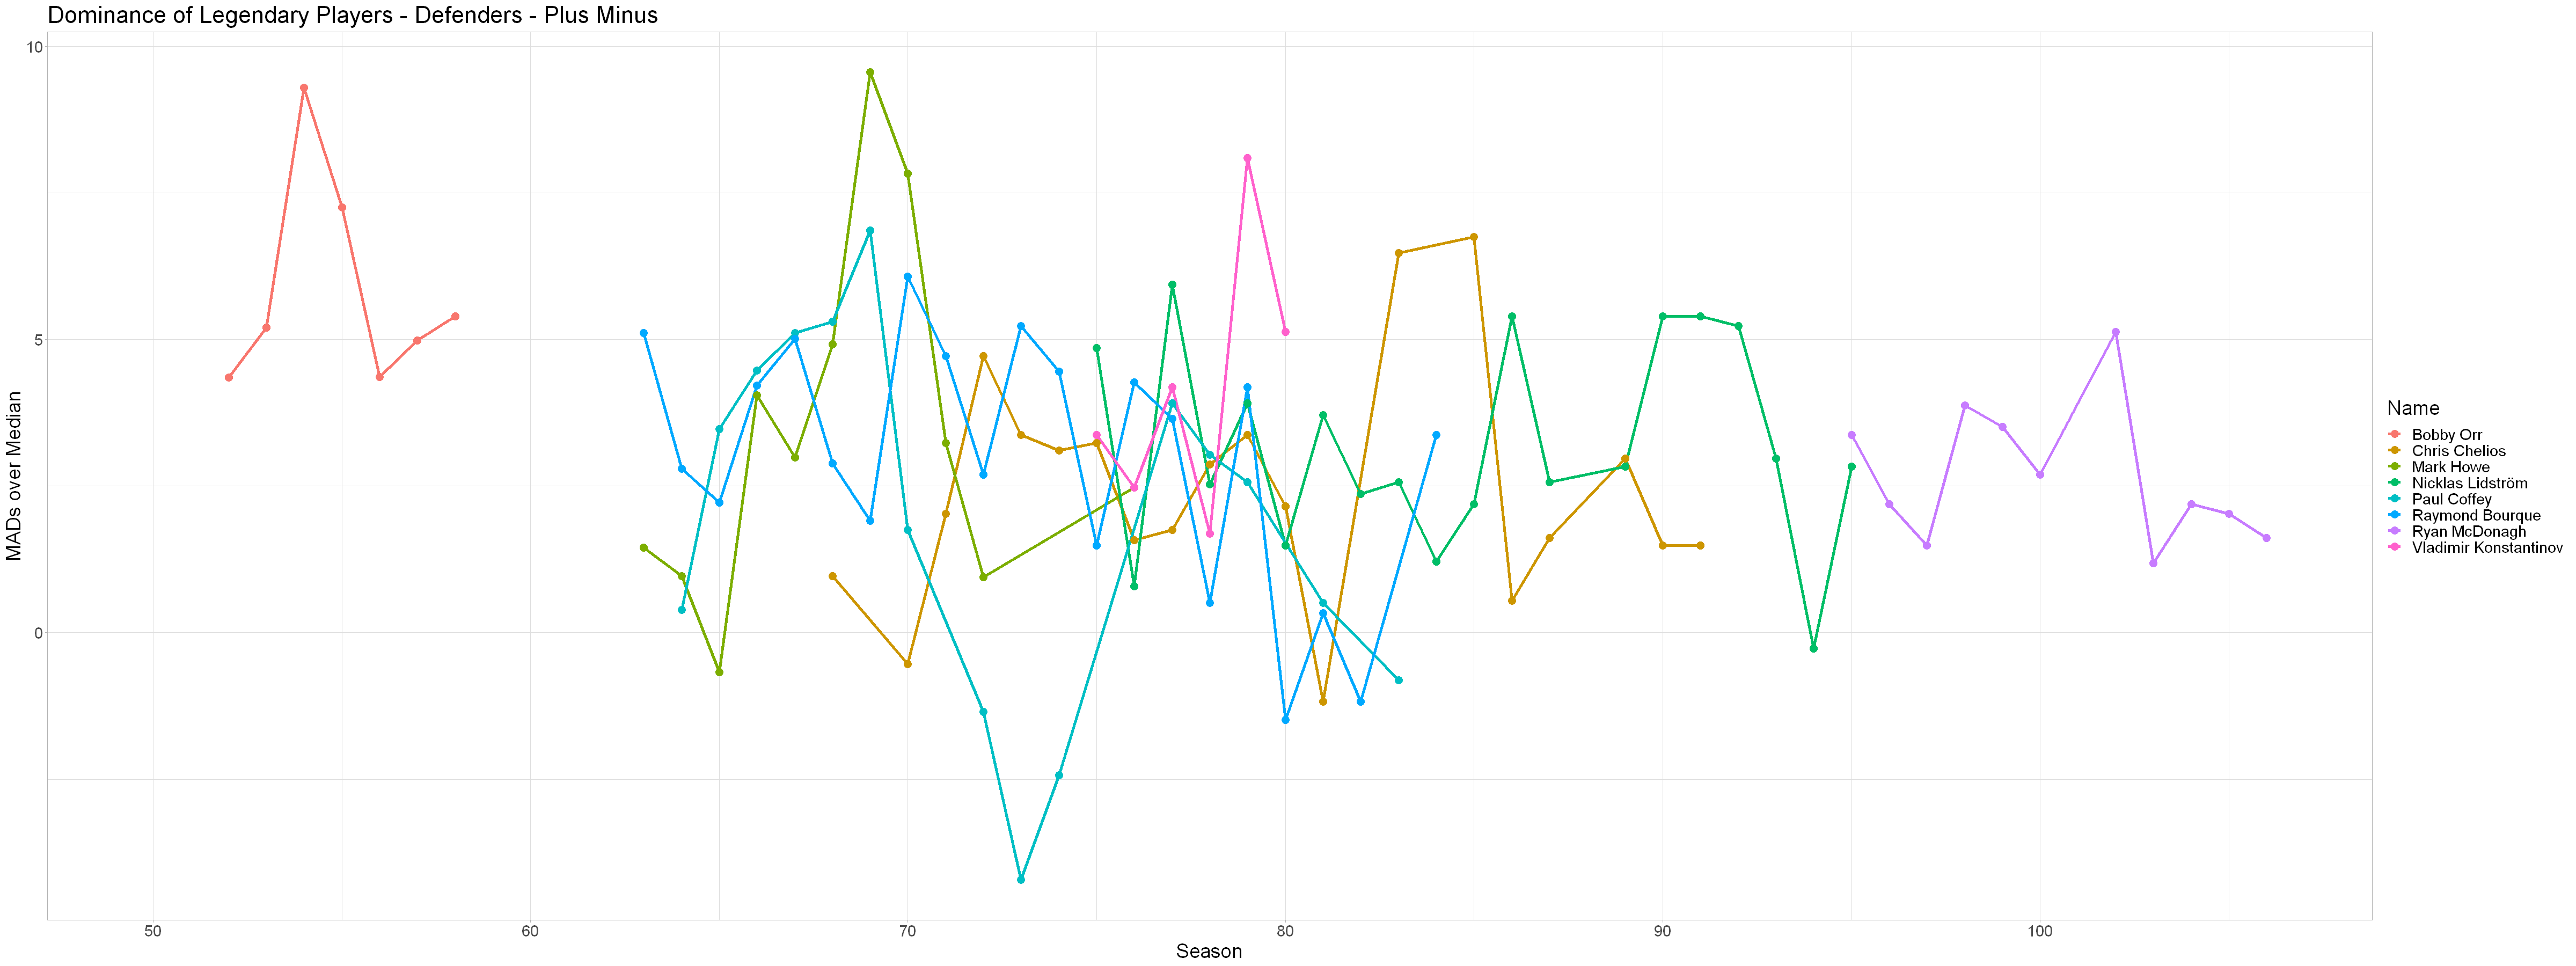

In [225]:
options(repr.plot.width = 40, repr.plot.height = 15)
defense_legends <- c("Bobby Orr", "Paul Coffey", "Raymond Bourque", "Vladimir Konstantinov", "Mark Howe", "Nicklas Lidström", "Chris Chelios", "Ryan McDonagh")
dominance_ps_d %>%
  filter(name %in% defense_legends) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
    labs(
      title = "Dominance of Legendary Players - Defenders - Plus Minus", 
      y = "MADs over Median", 
      x = "Season", 
      colour = "Name"
    ) + 
    geom_line(size = 1.5) + 
    geom_point(size = 4) + 
    def_plot_setup 

### Career Statistical Leaders Through Time

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

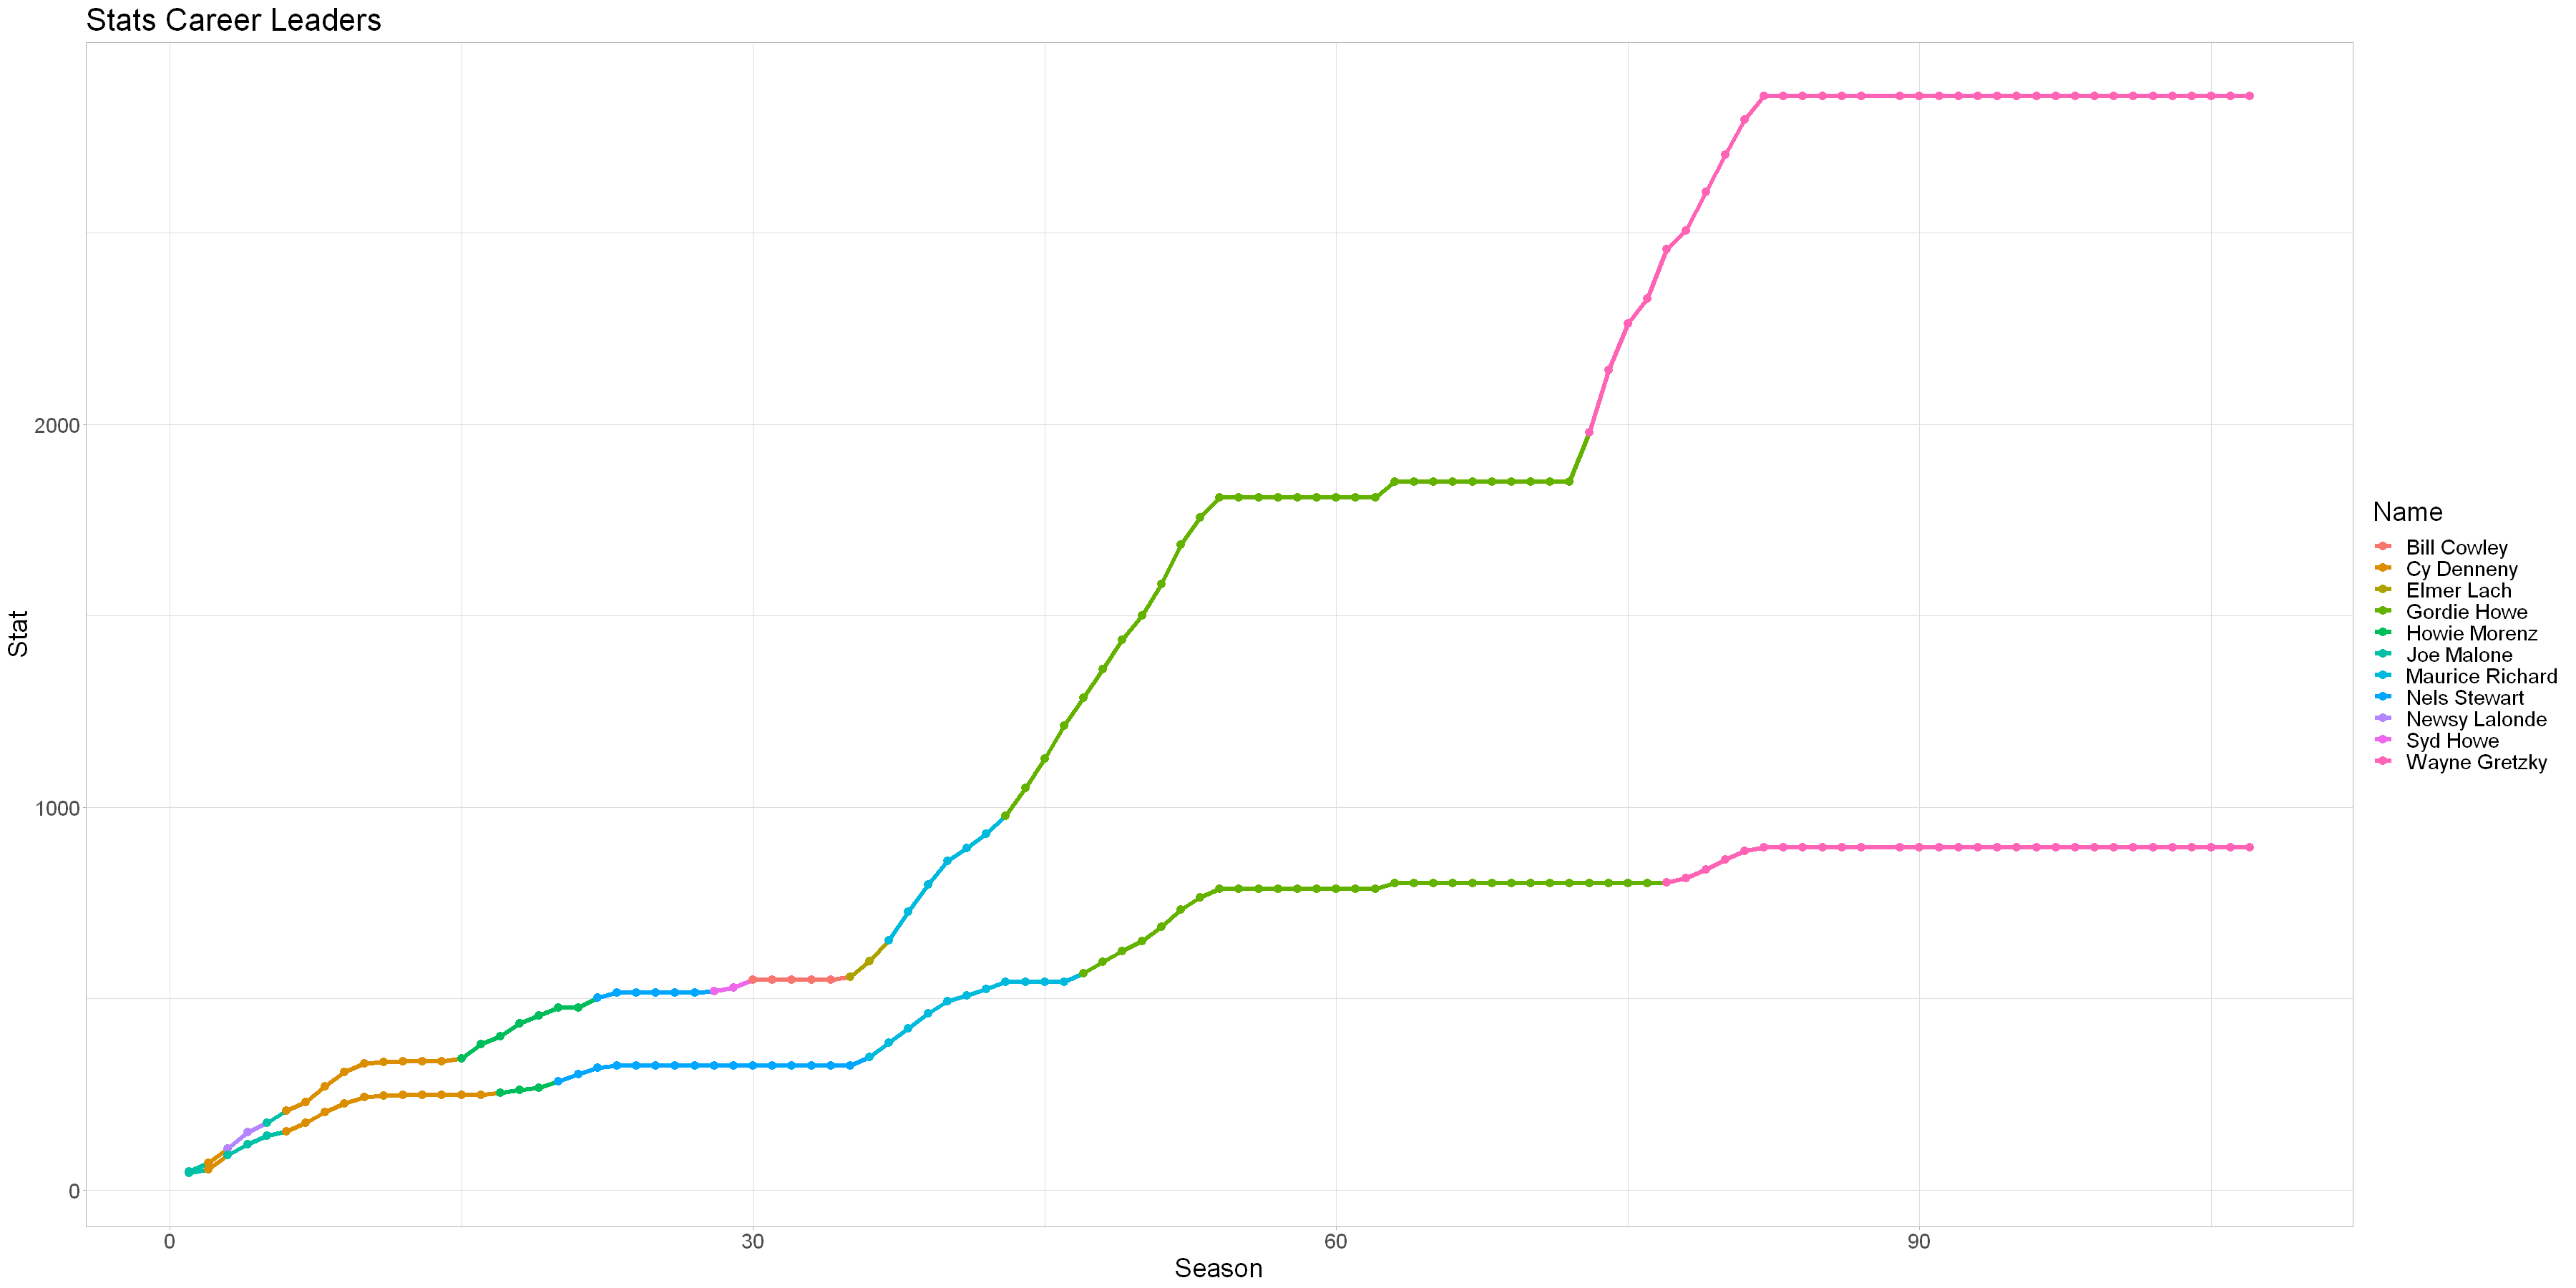

In [254]:
cum_sum <- player_data %>%
  filter(regular_season == 1) %>%
  group_by(name) %>%
  arrange(season_id) %>%
  mutate(cs_tp = cumsum(tp), cs_g = cumsum(g)) 

record_tp_1 <- cum_sum %>%
  group_by(season_id) %>%
  summarize(record_tp = max(cs_tp, na.rm=TRUE)) %>%
  left_join(
    cum_sum_tp, 
    by = join_by(record_tp == cs_tp, season_id == season_id)
    ) %>%
  select(season_id, name, record_tp, tp)

record_g <- cum_sum %>%
  group_by(season_id) %>%
  summarize(record_g = max(cs_g, na.rm = TRUE)) %>%
  left_join(cum_sum, by = join_by(record_g == cs_g, season_id == season_id)) %>%
  select(season_id, name, record_g, g)

for (ind in 2:nrow(record_tp_1)) {
  if (record_tp_1[ind - 1, 3] > record_tp_1[ind, 3]) {
    record_tp_1[ind, 3] <- record_tp_1[ind - 1, 3]
    record_tp_1[ind, 2] <- record_tp_1[ind - 1, 2]
  }
}
for (ind in 2:nrow(record_g)){
  if (record_g[ind - 1, 3] > record_g[ind, 3]) {
    record_g[ind, 3] <- record_g[ind - 1, 3]
    record_g[ind, 2] <- record_g[ind - 1, 2]
  }
}

record_all <- record_tp_1 %>%
  left_join(record_g, by = "season_id")

record_all %>%
  ggplot(., aes(x = season_id, y = record_tp, group = 1, colour = name.x))+
  geom_line(size = 1.75) + 
  geom_point(size = 3, aes(x = season_id, y = record_tp, colour = name.x)) + 
  geom_line(aes(x = season_id, y = record_g, group = 1, colour = name.y), size = 1.75) + 
  geom_point(size = 3, aes(x = season_id, y = record_g, colour = name.y)) + 
  def_plot_setup +
  labs(title = "Stats Career Leaders", x = "Season", y = "Stat", colour = "Name") 


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

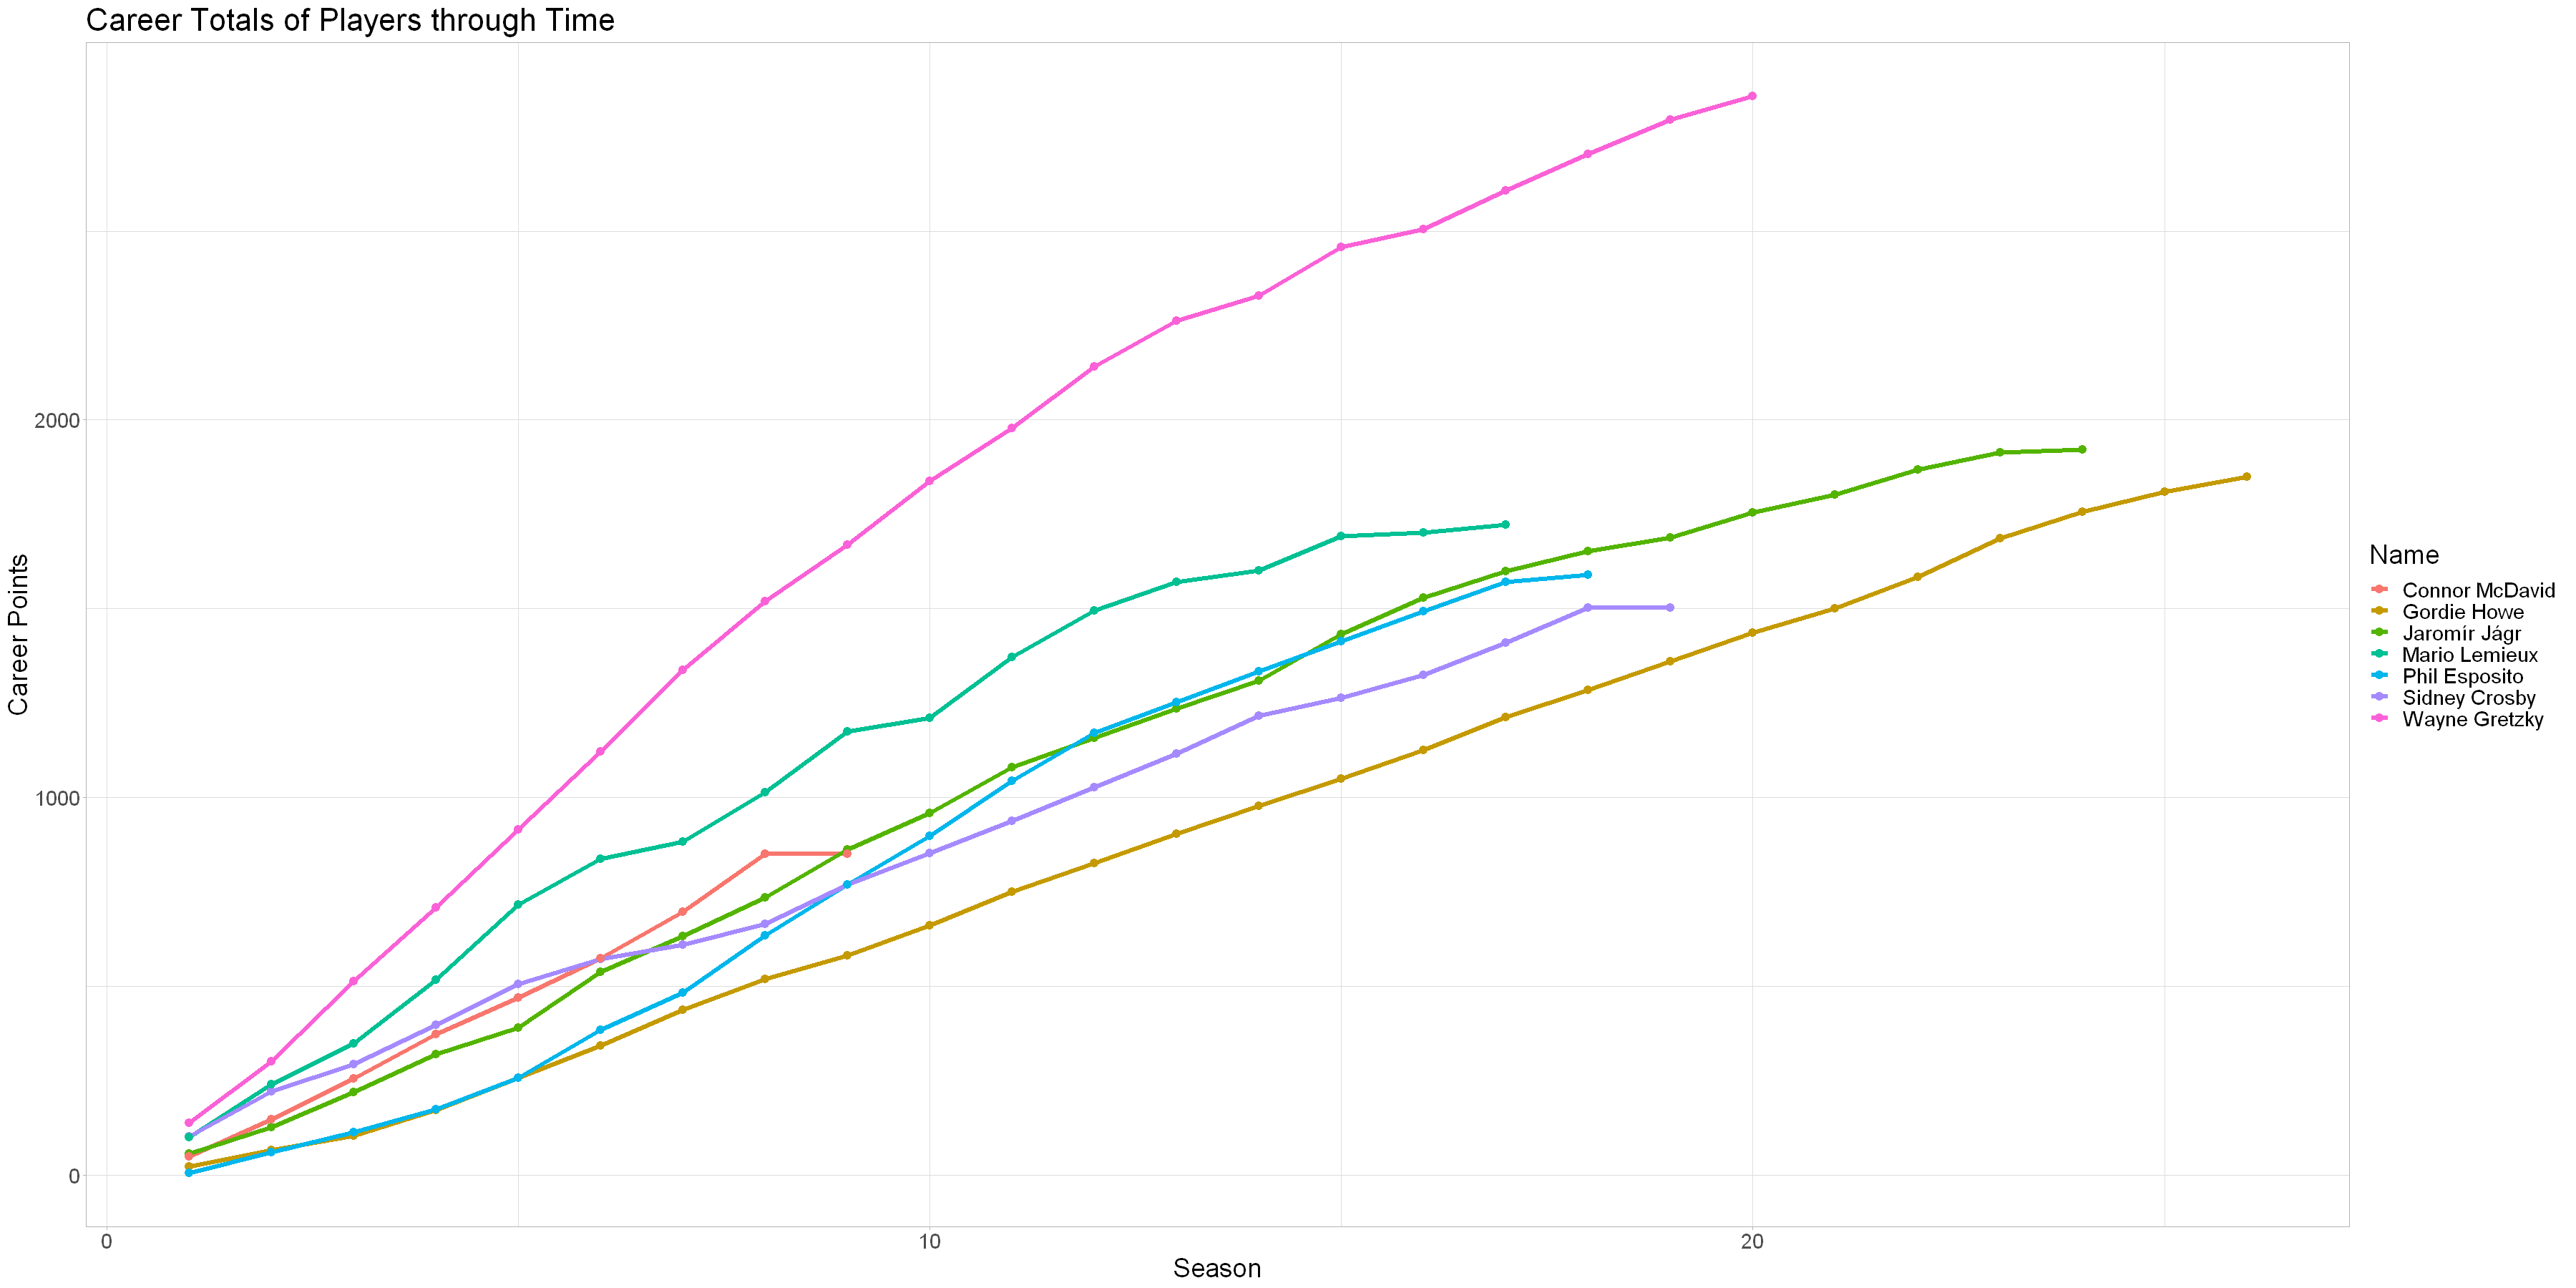

In [273]:
players_include <- c("Mario Lemieux", "Wayne Gretzky", "Gordie Howe", "Connor McDavid", "Jaromír Jágr", "Sidney Crosby", "Phil Esposito")
player_data %>%
  filter(regular_season == 1) %>%
  group_by(name) %>%
  mutate(season_player = row_number(season_id)) %>%
  group_by(name) %>%
  mutate(cum_tp = cumsum(tp)) %>%
  filter(name %in% players_include) %>%
ggplot(., aes(x = season_player, y = cum_tp, colour = name)) + 
  geom_line(size = 1.75) + 
  geom_point(size = 3) + 
  def_plot_setup +
  labs(
    title = "Career Totals of Players through Time", 
    x = "Season", 
    y = "Career Points", 
    colour ="Name"
  )

## Goalkeepers

### Save Percentage

In [358]:
dominance_svp <- create_comparative_measure(goalie_data, "goalie", 1, svp)
dominance_svp %>%
filter(season_id > 95)

u_id,name,season_id,season,catches,nationality,active,position,regular_season,gp,...,w,l,t,toi,gaa,svp,median_games,mad,median,measure
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
33246,Cam Talbot,97,2013-2014,L,Canada,1,G,1,21,...,12,6,1,1211,1.5714,0.9411,20.0,0.01067472,0.91320,2.613652
38007,Andrew Hammond,98,2014-2015,L,Canada,0,G,1,24,...,20,1,2,1411,1.7500,0.9406,17.5,0.01022994,0.91410,2.590436
19760,Linus Ullmark,106,2022-2023,L,Sweden,1,G,1,49,...,40,6,1,2883,1.8571,0.9375,19.0,0.01438122,0.90210,2.461544
11797,Ben Bishop,102,2018-2019,L,USA,0,G,1,46,...,27,15,2,2637,1.8913,0.9342,21.0,0.00934038,0.91170,2.408896
135425,Alex Nedeljkovic,104,2020-2021,L,USA,1,G,1,23,...,15,5,3,1392,1.9130,0.9321,14.5,0.01104537,0.90700,2.272445
9066,Craig Anderson,96,2012-2013,L,USA,0,G,1,24,...,12,9,2,1421,1.6667,0.9409,14.0,0.01430709,0.91025,2.142294
195577,Igor Shestyorkin,105,2021-2022,L,Russia,1,G,1,53,...,36,13,4,3071,2.0000,0.9346,12.0,0.01275036,0.90750,2.125430
11433,Curtis McElhinney,101,2017-2018,L,Canada,0,G,1,18,...,11,5,1,979,1.9444,0.9337,17.5,0.01000755,0.91245,2.123397
9308,Semyon Varlamov,104,2020-2021,L,Russia,1,G,1,36,...,19,11,4,2117,2.0000,0.9294,14.5,0.01104537,0.90700,2.027999


#### Carrer Highs

In [340]:
career_dominance_svp <- create_career_measure(dominance_svp)
career_dominance_svp <- career_dominance_svp %>%
filter(n >= median(n))
head(career_dominance_svp, 20)

name,measure,n
<chr>,<dbl>,<int>
Dominik Hasek,1.4642589,14
Patrick Roy,1.2694727,18
Tony Esposito,1.0619151,16
Jacques Plante,0.9262237,17
Tuukka Rask,0.9121168,12
Johnny Bower,0.9021450,12
Chico Resch,0.8869732,13
Bernie Parent,0.8592105,12
Roberto Luongo,0.6772366,19


Warning message:
"Removed 3 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_point()`)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot

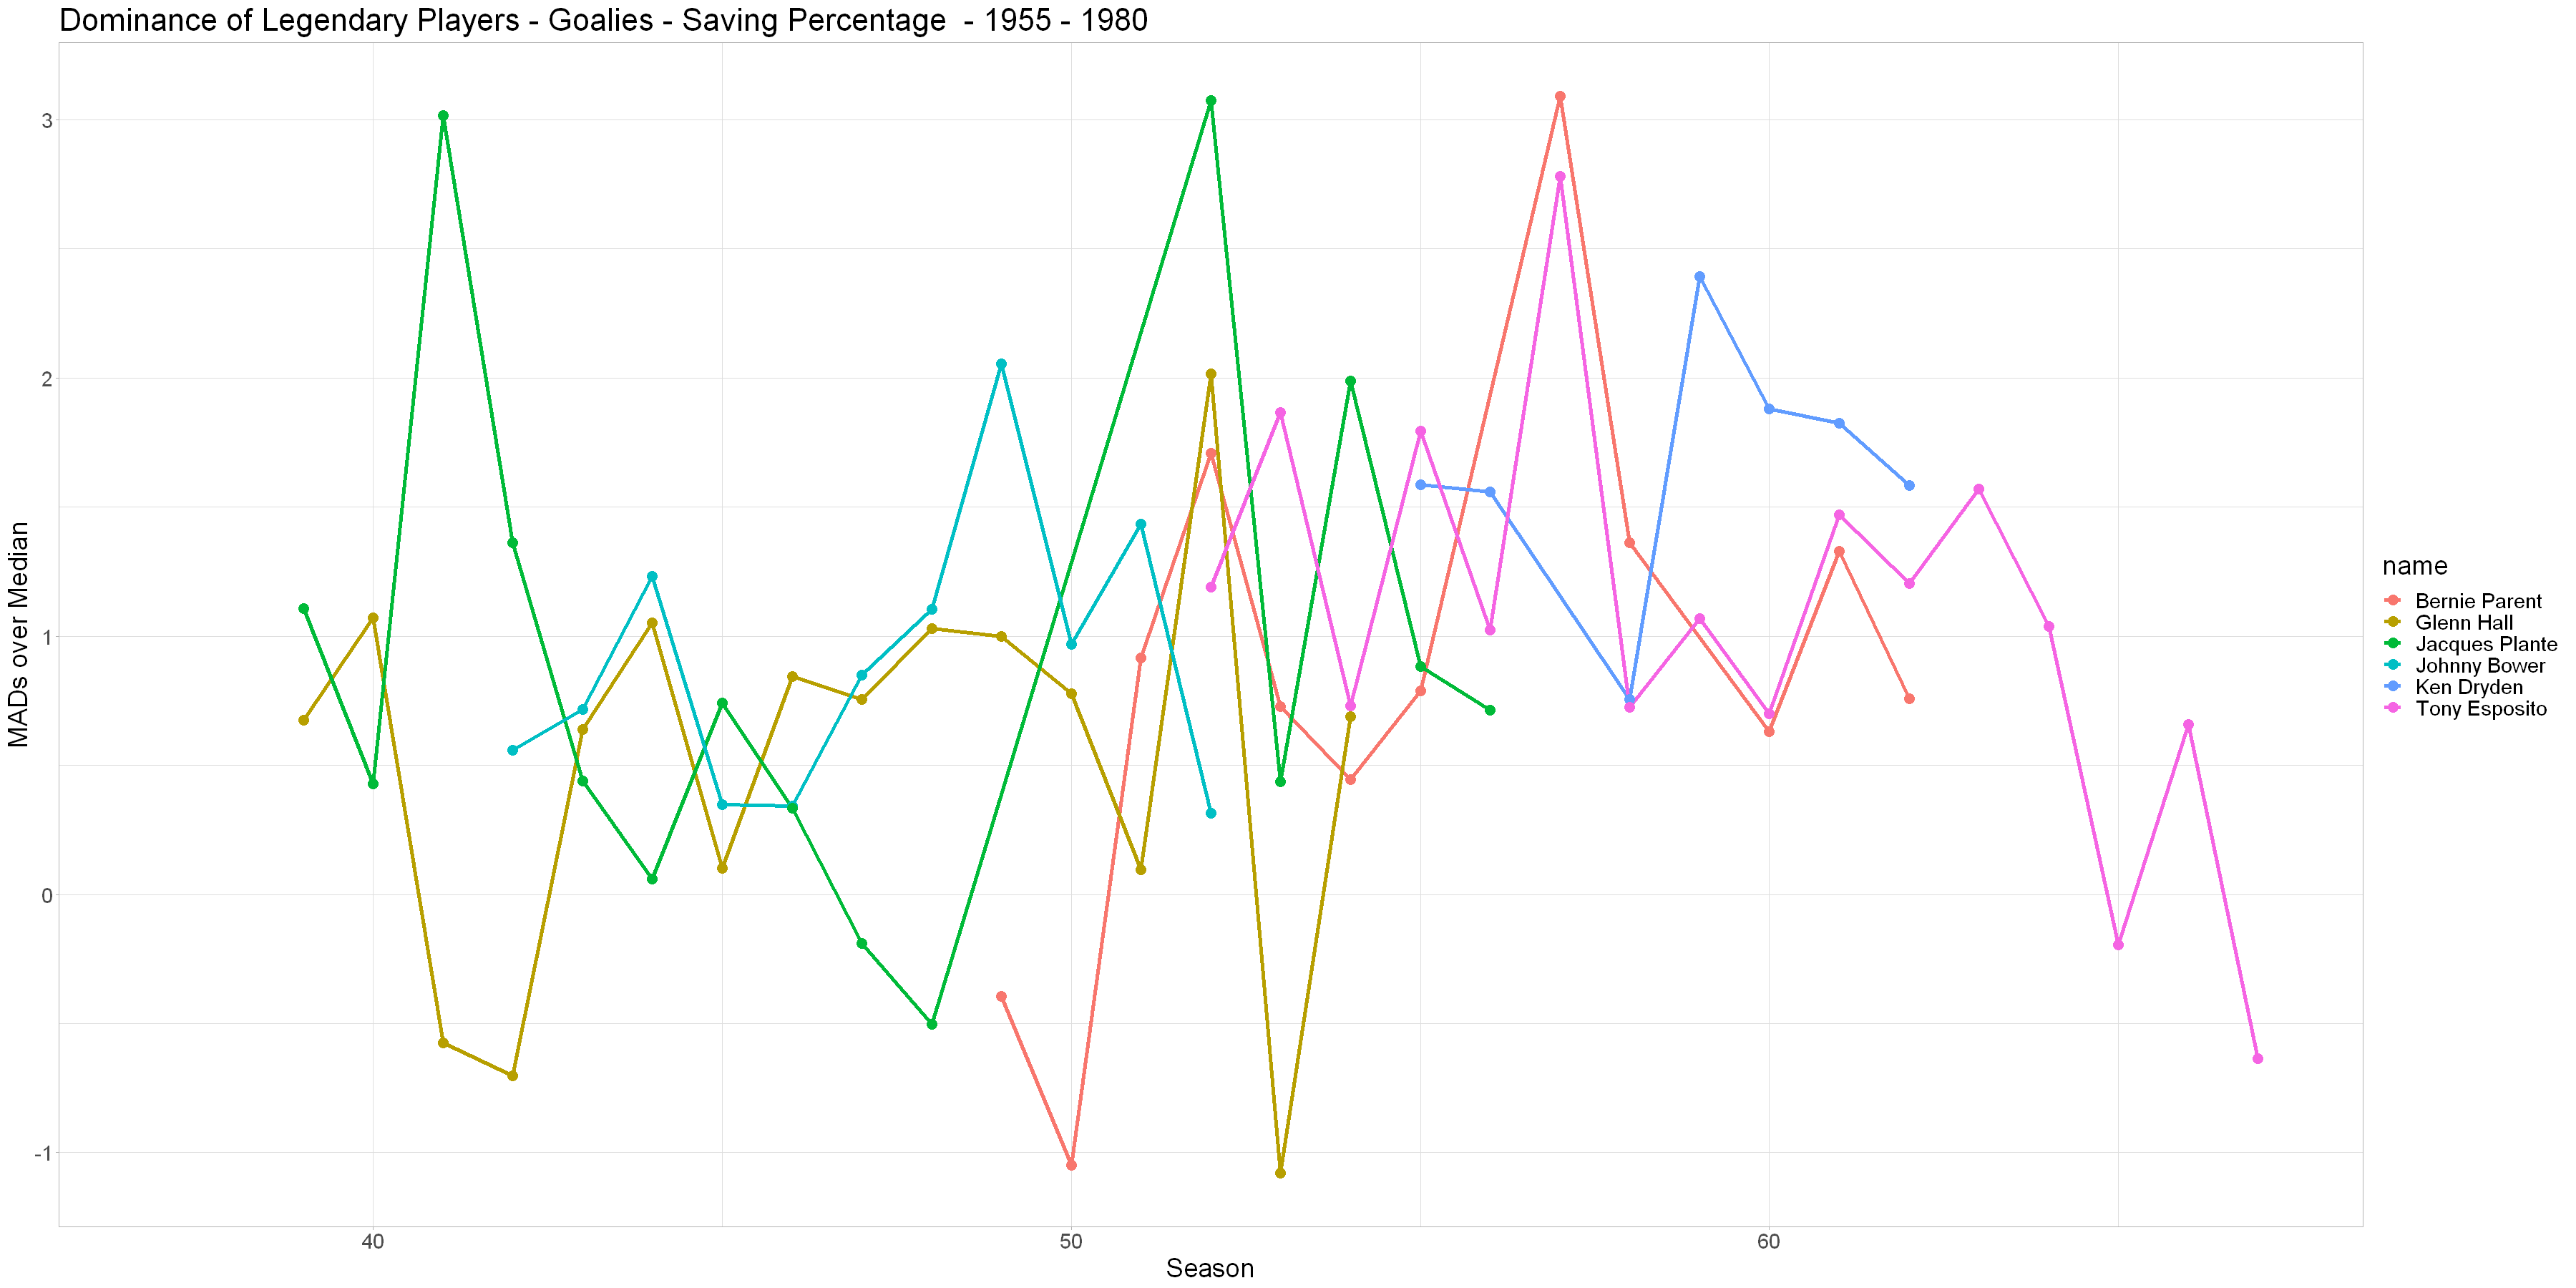

In [352]:
options(repr.plot.width = 30, repr.plot.height = 15)
goalie_legends <- c("Dominik Hasek", "Patrick Roy", "Tony Esposito", "Jacques Plante", 
"Henrik Lundqvist", "Martin Brodeur", "Ed Belfour", "Glenn Hall", "Johnny Bower", "Bernie Parent", 
"Ken Dryden", "Roberto Luongo")
dominance_svp %>%
  filter(name %in% goalie_legends) %>%
  filter(season_id < 68) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title = "Dominance of Legendary Players - Goalies - Saving Percentage  - 1955 - 1980", 
    y = "MADs over Median", 
    x = "Season"
    ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  def_plot_setup 


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

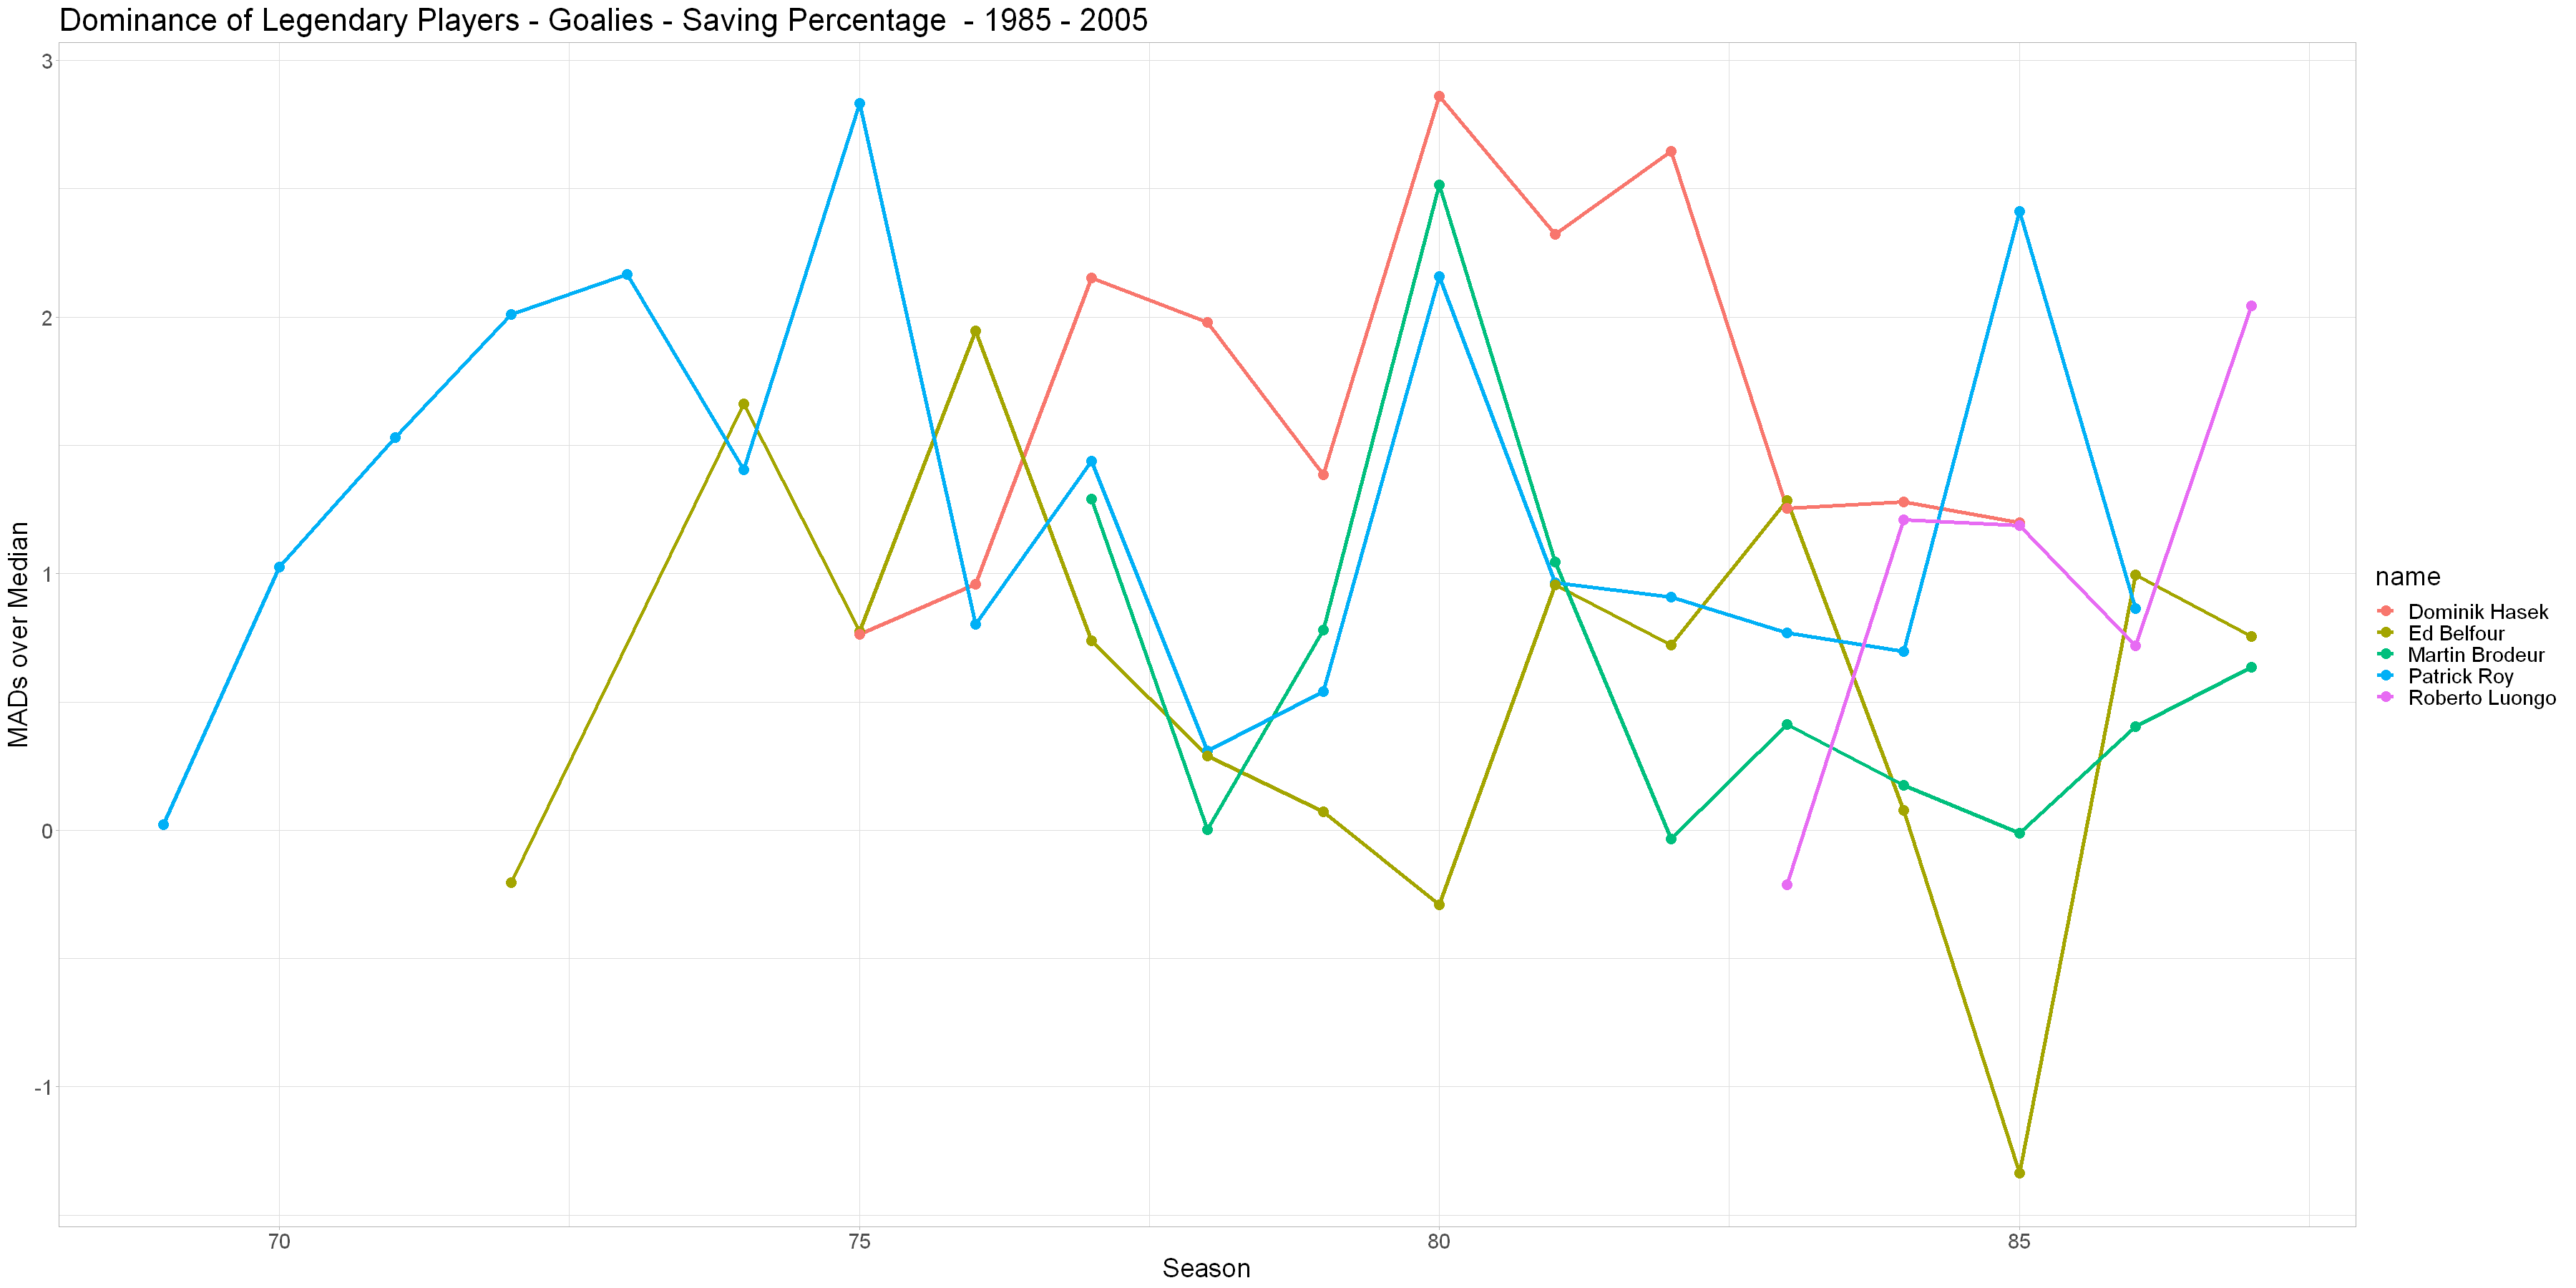

In [354]:
options(repr.plot.width = 30, repr.plot.height = 15)
goalie_legends <- c("Dominik Hasek", "Patrick Roy", "Tony Esposito", "Jacques Plante", 
"Henrik Lundqvist", "Martin Brodeur", "Ed Belfour", "Glenn Hall", "Johnny Bower", "Bernie Parent", 
"Ken Dryden", "Roberto Luongo")
dominance_svp %>%
  filter(name %in% goalie_legends) %>%
  filter(season_id < 88 & season_id > 68) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title = "Dominance of Legendary Players - Goalies - Saving Percentage  - 1985 - 2005", 
    y = "MADs over Median", 
    x = "Season"
    ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  def_plot_setup 

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

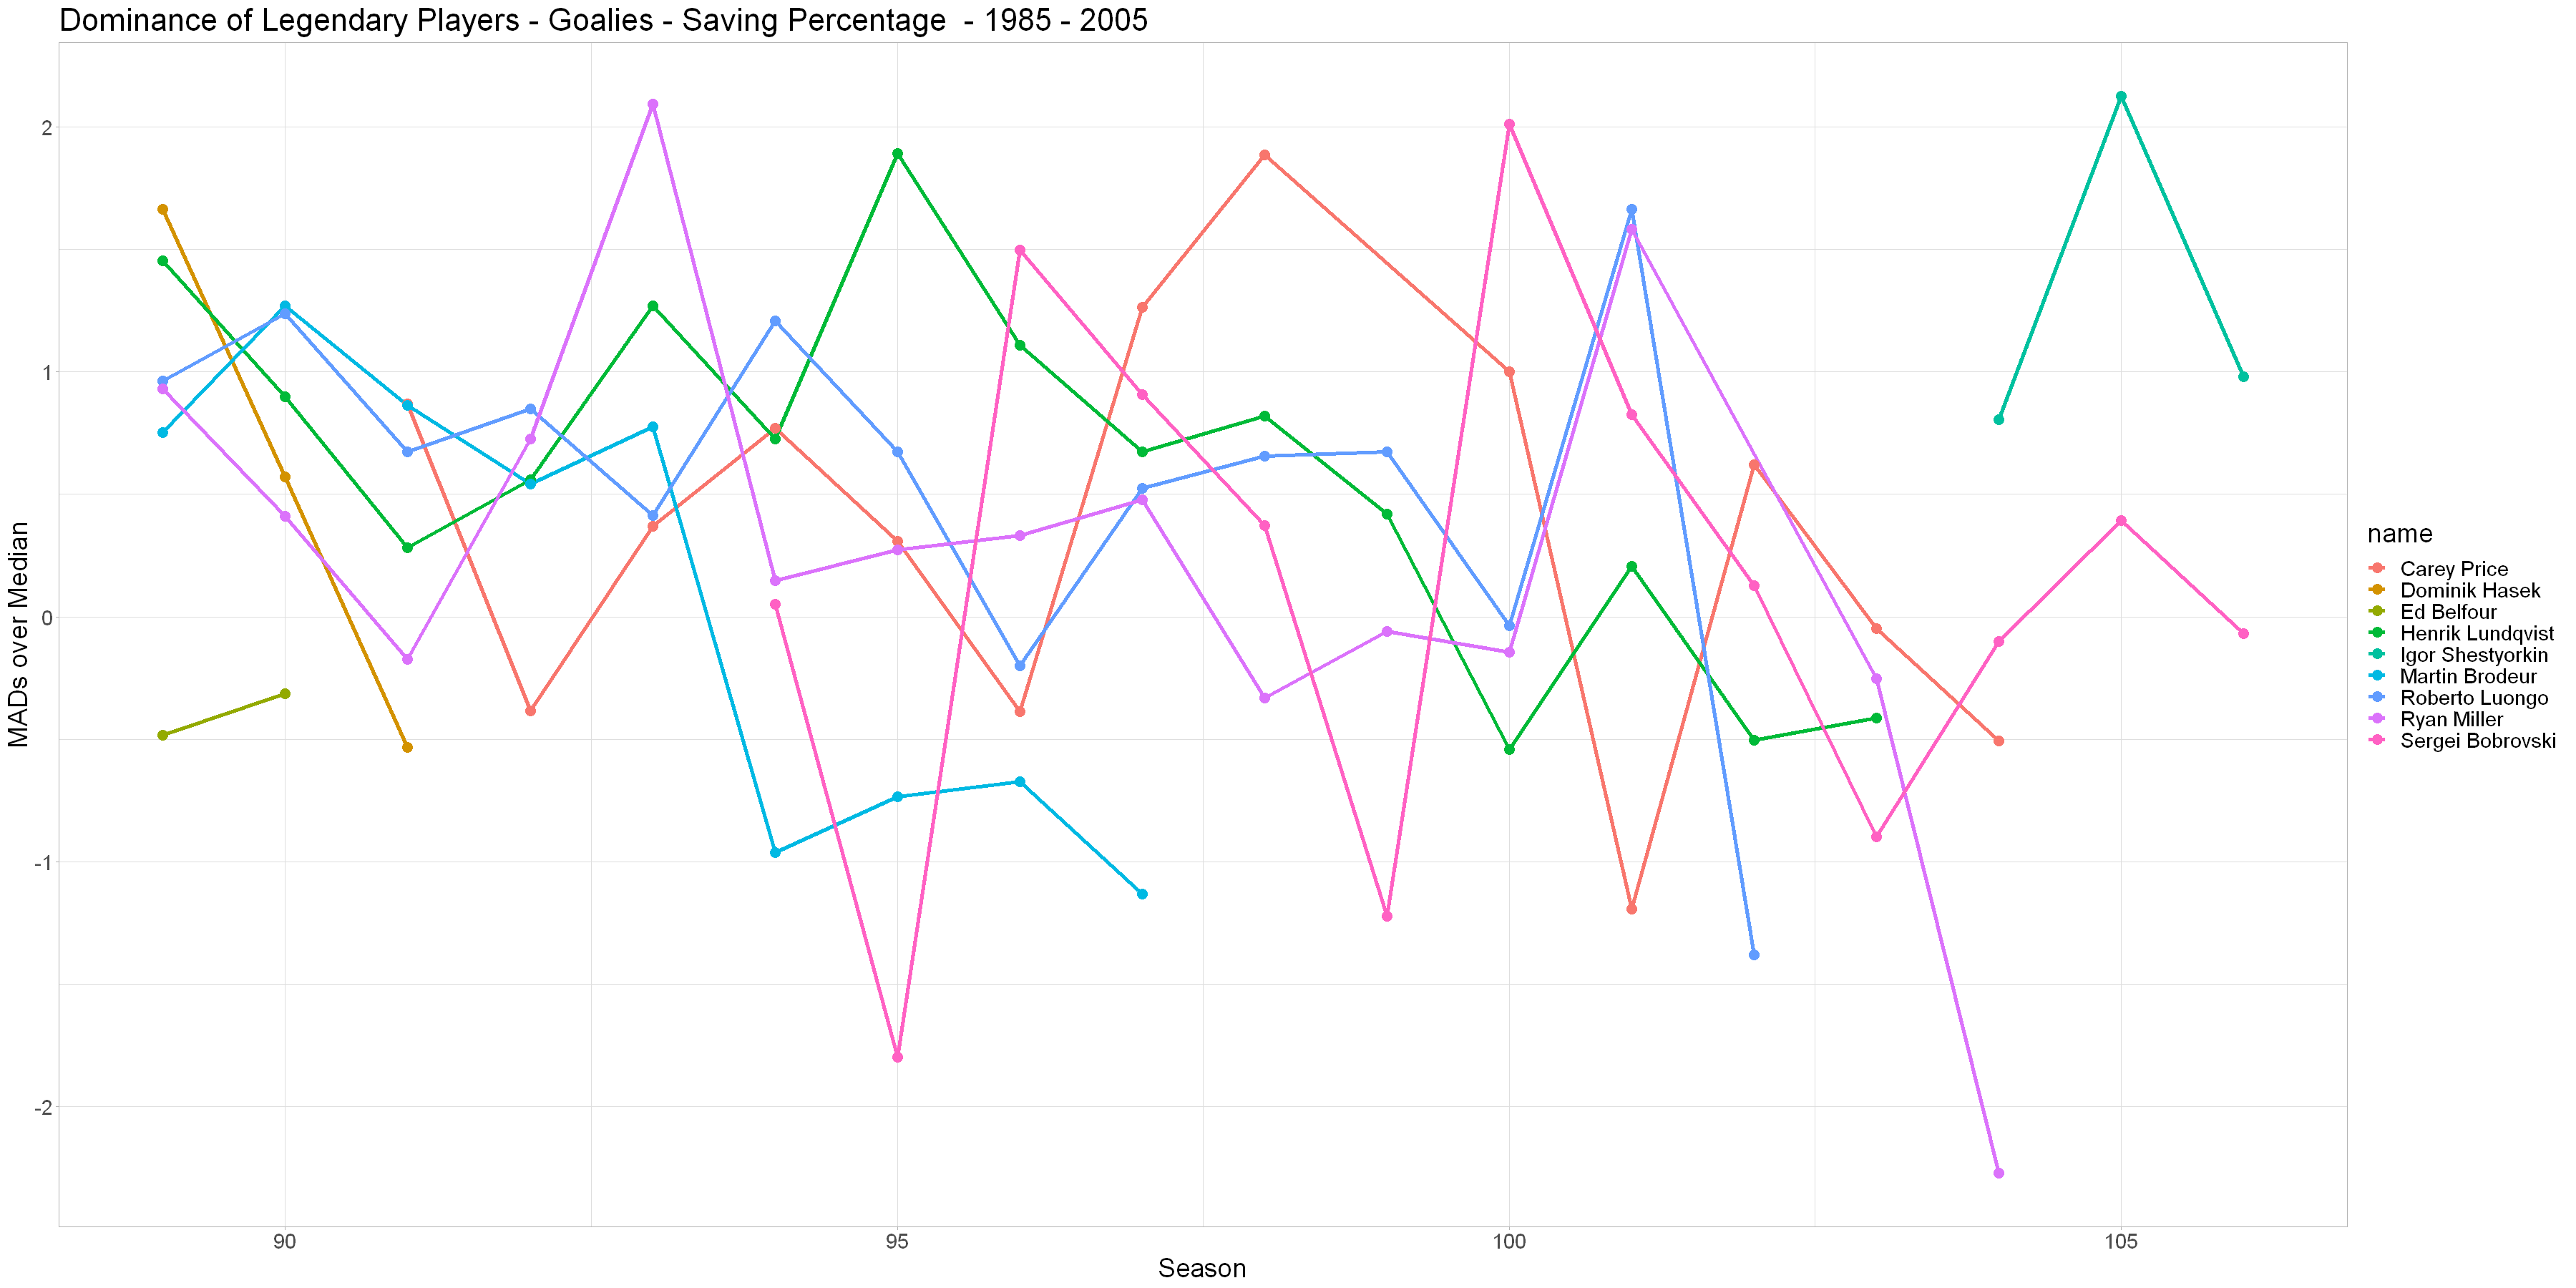

In [360]:
options(repr.plot.width = 30, repr.plot.height = 15)
goalie_legends <- c("Dominik Hasek", "Patrick Roy", "Tony Esposito", "Jacques Plante", 
"Henrik Lundqvist", "Martin Brodeur", "Ed Belfour", "Glenn Hall", "Johnny Bower", "Bernie Parent", 
"Ken Dryden", "Roberto Luongo", "Carey Price", "Sergei Bobrovski", "Ryan Miller", "Igor Shestyorkin")
dominance_svp %>%
  filter(name %in% goalie_legends) %>%
  filter(season_id > 88) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title = "Dominance of Legendary Players - Goalies - Saving Percentage  - 1985 - 2005", 
    y = "MADs over Median", 
    x = "Season"
    ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  def_plot_setup 

### 